# The MNIST Dataset
The MNIST dataset is a repository of handwritten digits with
- 60,000 training images
- 10,000 testing images
- 28x28x1 images


Will be trying to classify the class (numeric value) of the handwritten digit from the image using various DNN architectures.

- Multilayer Perceptron (MLP)
- Convolutional Neural Network (CNN)
- Graph Neural Network (GNN)

In [ ]:
#Basic pre-reqs:

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch
from torch import nn
import math
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MessagePassing, global_max_pool
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader
import torch.utils.data as data_utils
import torch_geometric
from torch_scatter import scatter_max
import dataclasses
import networkx as nx
from typing import *
from tqdm import tqdm
import os
import jax
from scipy.integrate import odeint
from torch_geometric.nn import GCNConv
import copy

from torch_geometric.utils import add_self_loops, degree, remove_self_loops

NUM_EPOCHS = 20
LR = 5e-4
device = torch.device("cuda")
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 8.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

## Load in the dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



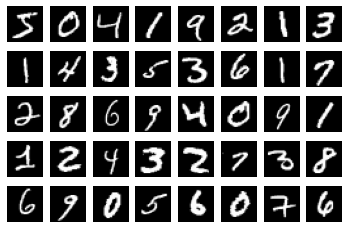

In [ ]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))]))
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))]))

# Use 1/10th of the dataset for efficiency purposes
mnist_train = data_utils.Subset(mnist_train, np.arange(len(mnist_train)//10))
mnist_test = data_utils.Subset(mnist_test, np.arange(len(mnist_test)//10))

for i in range(40):
    plt.subplot(5,8,i+1)
    plt.imshow(mnist_train[i][0].squeeze(), cmap="gray")
    plt.axis('off')

## Training Utilities

In [ ]:

@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """

    num_epochs: int
    lr: float

    # The trained model
    model: nn.Module

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # Training accuracies, before training and after each epoch
    train_accs: List[float]
    
    # Validation accuracies, before training and after each epoch
    val_accs: List[float]
        
def learning_curve(result: TrainResult, *, title: str = 'Learning Curve'):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses)) / len(result.train_losses) * result.num_epochs, 
        result.train_losses, 
        label='Train loss',
        color='C0',
    )
    ax_loss.set_ylim(0, max(result.train_losses))
    ax_loss.set_ylabel('Train loss', color='C0', fontsize=12)
    ax_loss.tick_params(axis='y', labelcolor='C0')

    ax_acc = ax_loss.twinx()
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.val_accs, label='Val', color='C1')
    else:
        l_valacc = ()
    ax_acc.set_ylim(0, max(max(result.val_accs), 1))
    ax_acc.set_ylabel('Validation', color='C1', fontsize=12)
    ax_acc.tick_params(axis='y', labelcolor='C1')

    lines = l_trloss + l_valacc

    ax_loss.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=13)
    
def train_nn(model, train_dataset, test_dataset, batch_size=32, num_epochs=NUM_EPOCHS, lr=LR, graph=False, criterion=nn.CrossEntropyLoss(), regression=False):
    
    train_result = TrainResult(num_epochs, lr, model, train_losses = [], train_accs=[], val_accs=[])
    
    if(graph):
        train_loader = torch_geometric.loader.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = torch_geometric.loader.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_train = 0
    for epoch in range(num_epochs):
        
        model.train()
        for datapoint in tqdm(train_loader):
            if(graph):
                datapoint = datapoint.to(device)
                X, y = datapoint, datapoint.y
            else:
                X, y = datapoint[0].to(device), datapoint[1].to(device)
            optimizer.zero_grad()
            output = model(X)
   
            loss = criterion(output, y)
            train_result.train_losses.append(loss.item())
            total_train += loss.item()
            loss.backward()
            optimizer.step()
        
        total_train = total_train/len(train_loader)

        model.eval()
        total_val = 0
        with torch.no_grad():
            for bidx, datapoint in enumerate(test_loader):
                if(graph):
                    datapoint = datapoint.to(device)
                    X, y = datapoint, datapoint.y
                else:
                    X, y = datapoint[0].to(device), datapoint[1].to(device)
                output = model(X)
                if(regression):
                    total_val += criterion(output, y).item()
                else:
                    total_val += torch.sum(torch.argmax(output, dim=-1)==y).item()/output.size(dim=0)
        train_result.val_accs.append(total_val/len(test_loader))

        if(regression):
            print("Epoch {}: Train Loss={} Validation Loss={}".format(epoch, total_train, train_result.val_accs[-1]))
        else:
            print("Epoch {}: Train Loss={} Validation Accuracy={}%".format(epoch, total_train, train_result.val_accs[-1]*100))

    return train_result

## MLP Architecture




In [ ]:
class MLP(nn.Module):
    def __init__(self, in_channels= 784, out_channels=10, num_hidden=128):

      super(MLP, self).__init__()
      self.flatten = nn.Flatten()
      self.layers = nn.ModuleList()
      self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_channels, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, out_channels)
        )

    def forward(self, x):

      x = self.flatten(x)
      x = self.linear_relu_stack(x)
      return x

## Train the MLP

100%|██████████| 188/188 [00:03<00:00, 47.02it/s] 


Epoch 0: Train Loss=0.9397408581794576 Validation Accuracy=85.15625%


100%|██████████| 188/188 [00:01<00:00, 116.72it/s]


Epoch 1: Train Loss=0.3345086240028771 Validation Accuracy=86.1328125%


100%|██████████| 188/188 [00:01<00:00, 122.74it/s]


Epoch 2: Train Loss=0.2351920344533943 Validation Accuracy=88.76953125%


100%|██████████| 188/188 [00:01<00:00, 122.32it/s]


Epoch 3: Train Loss=0.1826594913916556 Validation Accuracy=87.6953125%


100%|██████████| 188/188 [00:01<00:00, 120.85it/s]


Epoch 4: Train Loss=0.14159506292586566 Validation Accuracy=90.72265625%


100%|██████████| 188/188 [00:01<00:00, 120.13it/s]


Epoch 5: Train Loss=0.10919992898489514 Validation Accuracy=91.9921875%


100%|██████████| 188/188 [00:01<00:00, 124.01it/s]


Epoch 6: Train Loss=0.07980827375421098 Validation Accuracy=92.28515625%


100%|██████████| 188/188 [00:01<00:00, 121.89it/s]


Epoch 7: Train Loss=0.07486622524723241 Validation Accuracy=91.89453125%


100%|██████████| 188/188 [00:01<00:00, 122.18it/s]


Epoch 8: Train Loss=0.053636429941623286 Validation Accuracy=92.1875%


100%|██████████| 188/188 [00:01<00:00, 122.56it/s]


Epoch 9: Train Loss=0.050994143812287375 Validation Accuracy=93.75%


100%|██████████| 188/188 [00:01<00:00, 124.82it/s]


Epoch 10: Train Loss=0.044277719329242925 Validation Accuracy=92.3828125%


100%|██████████| 188/188 [00:01<00:00, 124.13it/s]


Epoch 11: Train Loss=0.03615787615090619 Validation Accuracy=93.75%


100%|██████████| 188/188 [00:01<00:00, 123.23it/s]


Epoch 12: Train Loss=0.026329286924782504 Validation Accuracy=93.84765625%


100%|██████████| 188/188 [00:01<00:00, 122.33it/s]


Epoch 13: Train Loss=0.030235309111556228 Validation Accuracy=94.140625%


100%|██████████| 188/188 [00:01<00:00, 125.02it/s]


Epoch 14: Train Loss=0.021527362152413097 Validation Accuracy=94.62890625%


100%|██████████| 188/188 [00:01<00:00, 126.92it/s]


Epoch 15: Train Loss=0.032657156398165695 Validation Accuracy=93.1640625%


100%|██████████| 188/188 [00:01<00:00, 123.26it/s]


Epoch 16: Train Loss=0.03206848019245821 Validation Accuracy=92.7734375%


100%|██████████| 188/188 [00:01<00:00, 121.04it/s]


Epoch 17: Train Loss=0.026885044065416218 Validation Accuracy=92.28515625%


100%|██████████| 188/188 [00:01<00:00, 109.72it/s]


Epoch 18: Train Loss=0.011546766455501959 Validation Accuracy=93.75%


100%|██████████| 188/188 [00:02<00:00, 86.56it/s]


Epoch 19: Train Loss=0.017400853382923926 Validation Accuracy=93.26171875%


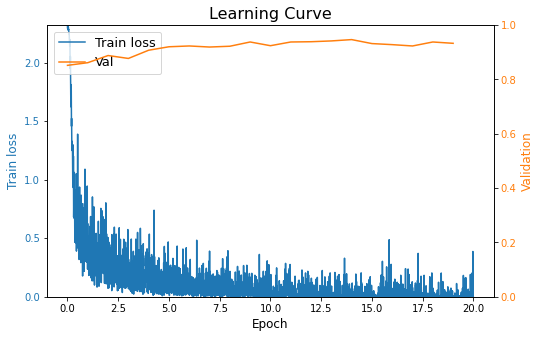

In [ ]:
model = MLP()
model.to(device)
mlp_mnist_results = train_nn(model, mnist_train, mnist_test)
learning_curve(mlp_mnist_results)

## CNN Architecture



In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=10, image_size=28):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels, 16, 5, 1, 2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.AdaptiveMaxPool2d((1, 1)),                
        )
        self.out = nn.Linear(32, out_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) 
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output


## Train the CNN

100%|██████████| 188/188 [00:02<00:00, 66.43it/s]


Epoch 0: Train Loss=1.5056666985471199 Validation Accuracy=87.01171875%


100%|██████████| 188/188 [00:03<00:00, 53.88it/s]


Epoch 1: Train Loss=0.3878810287791782 Validation Accuracy=92.1875%


100%|██████████| 188/188 [00:01<00:00, 126.52it/s]


Epoch 2: Train Loss=0.21990018044368714 Validation Accuracy=93.5546875%


100%|██████████| 188/188 [00:01<00:00, 129.52it/s]


Epoch 3: Train Loss=0.17394715180406314 Validation Accuracy=94.04296875%


100%|██████████| 188/188 [00:01<00:00, 122.98it/s]


Epoch 4: Train Loss=0.1378369411714063 Validation Accuracy=93.45703125%


100%|██████████| 188/188 [00:01<00:00, 124.73it/s]


Epoch 5: Train Loss=0.11896105080737934 Validation Accuracy=94.921875%


100%|██████████| 188/188 [00:01<00:00, 125.85it/s]


Epoch 6: Train Loss=0.10147105042782469 Validation Accuracy=95.01953125%


100%|██████████| 188/188 [00:01<00:00, 127.52it/s]


Epoch 7: Train Loss=0.0883721773540877 Validation Accuracy=96.09375%


100%|██████████| 188/188 [00:01<00:00, 123.58it/s]


Epoch 8: Train Loss=0.07694513926809134 Validation Accuracy=95.41015625%


100%|██████████| 188/188 [00:01<00:00, 127.38it/s]


Epoch 9: Train Loss=0.07068491390592029 Validation Accuracy=95.99609375%


100%|██████████| 188/188 [00:01<00:00, 127.82it/s]


Epoch 10: Train Loss=0.06250969046284259 Validation Accuracy=96.19140625%


100%|██████████| 188/188 [00:01<00:00, 126.20it/s]


Epoch 11: Train Loss=0.055246218881952476 Validation Accuracy=95.80078125%


100%|██████████| 188/188 [00:01<00:00, 126.63it/s]


Epoch 12: Train Loss=0.05123571324836607 Validation Accuracy=95.8984375%


100%|██████████| 188/188 [00:01<00:00, 125.69it/s]


Epoch 13: Train Loss=0.043922944096933786 Validation Accuracy=96.2890625%


100%|██████████| 188/188 [00:01<00:00, 126.31it/s]


Epoch 14: Train Loss=0.040032928375369196 Validation Accuracy=96.484375%


100%|██████████| 188/188 [00:01<00:00, 126.94it/s]


Epoch 15: Train Loss=0.03586854255760123 Validation Accuracy=95.8984375%


100%|██████████| 188/188 [00:01<00:00, 123.76it/s]


Epoch 16: Train Loss=0.0314151043604139 Validation Accuracy=96.38671875%


100%|██████████| 188/188 [00:01<00:00, 128.46it/s]


Epoch 17: Train Loss=0.03145791739736674 Validation Accuracy=96.6796875%


100%|██████████| 188/188 [00:01<00:00, 119.09it/s]


Epoch 18: Train Loss=0.030976281573086867 Validation Accuracy=96.09375%


100%|██████████| 188/188 [00:01<00:00, 125.85it/s]


Epoch 19: Train Loss=0.02480509655496633 Validation Accuracy=96.97265625%


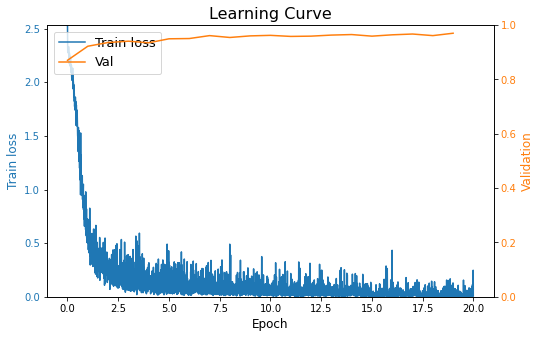

In [ ]:
model = CNN()
model.to(device)
cnn_mnist_results = train_nn(model, mnist_train, mnist_test)
learning_curve(cnn_mnist_results)

## GNN Architecture

Graph neural networks subscribe to a slightly different API from [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/). In addition to the input features of shape [N, in_channels] for N nodes and `in_channels` node features per node, they also expect an edge_index tensor of shape [2, E] for E edges that specifies the *structure* of the graph.

Instead of sliding window convolutions used in the CNN, Graph neural networks use graph convolutions implemented via message passing. There are many ways to aggregate and normalize messages during graph convolutions. [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) (GCN). 

GCNs normalize the messages by *both* the degrees from the source node and target node. More specifically, GCN message passing has the following form.

$$x_i^{(k)} = \sum_{j\in{\mathcal{N}(i)\cup{\{i\}}}}C\Big(W\cdot{x_j^{(k-1)}}\Big)+b$$


$$C=\frac{1}{\sqrt{\text{deg}(i)}\cdot\sqrt{\text{deg}(j)}}$$




In [ ]:

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        #  Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # print('done')
        #  Linearly transform node feature matrix.
        # print(x.shape, flush=True)
        x = self.lin(x)
        

        # Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Normalize node features.
        return norm.view(-1, 1) * x_j



class GNN(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels = 10):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.linear1 = torch.nn.Linear(64,64)
        self.linear2 = torch.nn.Linear(64,out_channels)

    def forward(self, data):
        # Graph convolutional layers
        x, edge_index = data.x, data.edge_index
        # print('first', flush=True)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))

        out, _ = scatter_max(x, data.batch, dim = 0)

        # linear
        data = F.relu(self.linear1(out))
        data = self.linear2(data)
        return data

## GNN Utilities

In [ ]:
def tograph(dataset, edge_matrix_fn, position_encoding=False):
    new_dataset = []
    for i in tqdm(range(len(dataset))):
        adjacency_matrix = edge_matrix_fn(dataset[i][0])
        x = torch.flatten(dataset[i][0])
        active, = np.where(np.sum(adjacency_matrix, axis=1)>0)
        if(position_encoding):
            positions1 = torch.flatten(torch.tensor((np.repeat(np.expand_dims(np.arange(28)/28.0, axis=0), 28 , axis=0)))).type(torch.FloatTensor)
            positions2 = torch.flatten(torch.tensor((np.repeat(np.expand_dims(np.arange(28)/28.0, axis=0), 28, axis=0).T))).type(torch.FloatTensor)
            stacked = torch.cat([torch.unsqueeze(x, 1), torch.unsqueeze(positions1, 1), torch.unsqueeze(positions2, 1)], dim=1)
        else:
            stacked = torch.cat([torch.unsqueeze(x, 1)], dim=1)

        x = Variable(stacked[active, :])
        edge_matrix = torch.tensor(adjacency_matrix[active, :][:, active])
        edge_index = edge_matrix.nonzero().t().contiguous()
        y = Variable(torch.tensor([dataset[i][1]]))
        new_dataset.append(Data(x, edge_index=edge_index, y=y))
    return new_dataset
    
    
def plot_adjacency_matrix(matrix):
    G = nx.Graph()
    nodes = []
    pos = {}
    for x1 in range(int(math.sqrt(matrix.shape[0]))):
        for x2 in range(int(math.sqrt(matrix.shape[0]))):
            node = len(nodes)
            pos[node] = (x2, 28-x1)
            nodes.append(node)
    edges = []
    for node1 in range(len(nodes)):
        for node2 in range(len(nodes)):
            if(matrix[node1, node2]>0 and node1!=node2):
                edges.append((node1, node2))
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, node_size=10, width = [1 for _ in range(len(edges))])

## GNN dataset and training




100%|██████████| 1000/1000 [00:07<00:00, 137.33it/s]


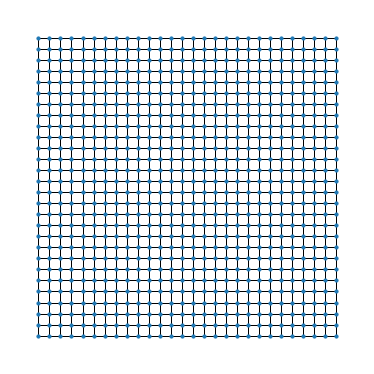

In [ ]:
def uniform_edge_matrix(x):
    W = 28
    grid_matrix = np.zeros((W**2, W**2))
    for i in range(W):
        for j in range(W):
            if(i>=1):
                grid_matrix[i*W+j, (i-1)*W+j] = 1
            if(i<27):
                grid_matrix[i*W+j, (i+1)*W+j] = 1
            if(j>=1):
                grid_matrix[i*W+j, (i)*W+(j-1)] = 1
            if(j<27):
                grid_matrix[i*W+j, (i)*W+(j+1)] = 1
    return grid_matrix


plot_adjacency_matrix(uniform_edge_matrix(mnist_train[0]))

mnist_train_uniform = tograph(mnist_train, uniform_edge_matrix, position_encoding=False)
mnist_test_uniform = tograph(mnist_test, uniform_edge_matrix, position_encoding=False)

mnist_train_uniform_pe = tograph(mnist_train, uniform_edge_matrix, position_encoding=True)
mnist_test_uniform_pe = tograph(mnist_test, uniform_edge_matrix, position_encoding=True)

100%|██████████| 188/188 [00:02<00:00, 86.80it/s]


Epoch 0: Train Loss=2.3007272849691676 Validation Accuracy=9.765625%


100%|██████████| 188/188 [00:01<00:00, 94.80it/s]


Epoch 1: Train Loss=2.3103802719702813 Validation Accuracy=11.1328125%


100%|██████████| 188/188 [00:01<00:00, 94.23it/s]


Epoch 2: Train Loss=2.3073785117538 Validation Accuracy=13.37890625%


100%|██████████| 188/188 [00:01<00:00, 95.25it/s]


Epoch 3: Train Loss=2.3002587987024263 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 95.62it/s]


Epoch 4: Train Loss=2.289709374854454 Validation Accuracy=16.9921875%


100%|██████████| 188/188 [00:01<00:00, 96.17it/s]


Epoch 5: Train Loss=2.277761146349843 Validation Accuracy=16.69921875%


100%|██████████| 188/188 [00:01<00:00, 94.81it/s]


Epoch 6: Train Loss=2.263320805781927 Validation Accuracy=17.7734375%


100%|██████████| 188/188 [00:01<00:00, 95.49it/s]


Epoch 7: Train Loss=2.2237614792826004 Validation Accuracy=21.484375%


100%|██████████| 188/188 [00:01<00:00, 96.32it/s]


Epoch 8: Train Loss=2.1474300923088774 Validation Accuracy=21.58203125%


100%|██████████| 188/188 [00:01<00:00, 96.20it/s]


Epoch 9: Train Loss=2.081784011995401 Validation Accuracy=25.29296875%


100%|██████████| 188/188 [00:01<00:00, 95.03it/s]


Epoch 10: Train Loss=2.045988686552261 Validation Accuracy=24.21875%


100%|██████████| 188/188 [00:01<00:00, 96.50it/s]


Epoch 11: Train Loss=2.02457809959569 Validation Accuracy=22.16796875%


100%|██████████| 188/188 [00:01<00:00, 96.12it/s]


Epoch 12: Train Loss=2.008140158173184 Validation Accuracy=22.4609375%


100%|██████████| 188/188 [00:01<00:00, 96.77it/s]


Epoch 13: Train Loss=1.9914345675300873 Validation Accuracy=25.68359375%


100%|██████████| 188/188 [00:01<00:00, 96.25it/s]


Epoch 14: Train Loss=1.9795341110893128 Validation Accuracy=25.87890625%


100%|██████████| 188/188 [00:01<00:00, 95.24it/s]


Epoch 15: Train Loss=1.972717813152301 Validation Accuracy=25.390625%


100%|██████████| 188/188 [00:01<00:00, 94.80it/s]


Epoch 16: Train Loss=1.9661535604387852 Validation Accuracy=22.8515625%


100%|██████████| 188/188 [00:02<00:00, 92.99it/s]


Epoch 17: Train Loss=1.9572125923673684 Validation Accuracy=25.5859375%


100%|██████████| 188/188 [00:01<00:00, 95.28it/s]


Epoch 18: Train Loss=1.9473706123740326 Validation Accuracy=26.26953125%


100%|██████████| 188/188 [00:01<00:00, 96.13it/s]


Epoch 19: Train Loss=1.9424956832147187 Validation Accuracy=27.44140625%


100%|██████████| 188/188 [00:02<00:00, 85.45it/s]


Epoch 0: Train Loss=2.2998465261560805 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:02<00:00, 87.41it/s]


Epoch 1: Train Loss=2.2097055880110856 Validation Accuracy=34.5703125%


100%|██████████| 188/188 [00:02<00:00, 88.84it/s]


Epoch 2: Train Loss=1.669006149802585 Validation Accuracy=45.703125%


100%|██████████| 188/188 [00:02<00:00, 87.74it/s]


Epoch 3: Train Loss=1.353154028248459 Validation Accuracy=55.17578125%


100%|██████████| 188/188 [00:02<00:00, 89.12it/s]


Epoch 4: Train Loss=1.1701630421817286 Validation Accuracy=55.078125%


100%|██████████| 188/188 [00:02<00:00, 88.92it/s]


Epoch 5: Train Loss=1.071423085482165 Validation Accuracy=61.03515625%


100%|██████████| 188/188 [00:02<00:00, 88.50it/s]


Epoch 6: Train Loss=0.9936983266829559 Validation Accuracy=62.3046875%


100%|██████████| 188/188 [00:02<00:00, 89.40it/s]


Epoch 7: Train Loss=0.9516225271610499 Validation Accuracy=63.8671875%


100%|██████████| 188/188 [00:02<00:00, 89.20it/s]


Epoch 8: Train Loss=0.9017740889713634 Validation Accuracy=65.8203125%


100%|██████████| 188/188 [00:02<00:00, 89.15it/s]


Epoch 9: Train Loss=0.874031951983519 Validation Accuracy=66.015625%


100%|██████████| 188/188 [00:02<00:00, 88.93it/s]


Epoch 10: Train Loss=0.8547814086870085 Validation Accuracy=63.4765625%


100%|██████████| 188/188 [00:02<00:00, 88.80it/s]


Epoch 11: Train Loss=0.8268842853530691 Validation Accuracy=67.96875%


100%|██████████| 188/188 [00:02<00:00, 90.20it/s]


Epoch 12: Train Loss=0.8058283518484216 Validation Accuracy=62.98828125%


100%|██████████| 188/188 [00:02<00:00, 87.40it/s]


Epoch 13: Train Loss=0.7999570140869963 Validation Accuracy=70.1171875%


100%|██████████| 188/188 [00:02<00:00, 87.07it/s]


Epoch 14: Train Loss=0.7745731229211589 Validation Accuracy=68.65234375%


100%|██████████| 188/188 [00:02<00:00, 88.85it/s]


Epoch 15: Train Loss=0.753632029666242 Validation Accuracy=69.43359375%


100%|██████████| 188/188 [00:02<00:00, 89.45it/s]


Epoch 16: Train Loss=0.7429423073334355 Validation Accuracy=70.21484375%


100%|██████████| 188/188 [00:02<00:00, 88.57it/s]


Epoch 17: Train Loss=0.7175873457959584 Validation Accuracy=72.265625%


100%|██████████| 188/188 [00:02<00:00, 88.46it/s]


Epoch 18: Train Loss=0.7048289669318673 Validation Accuracy=71.97265625%


100%|██████████| 188/188 [00:02<00:00, 88.67it/s]


Epoch 19: Train Loss=0.6925074787283428 Validation Accuracy=73.828125%


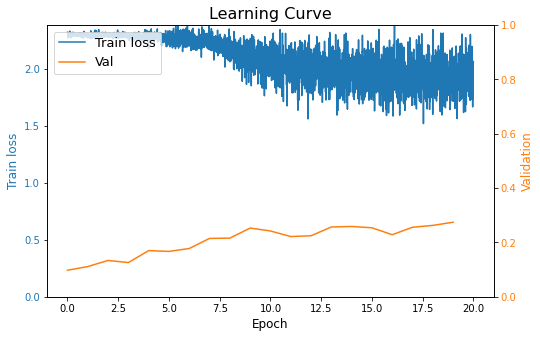

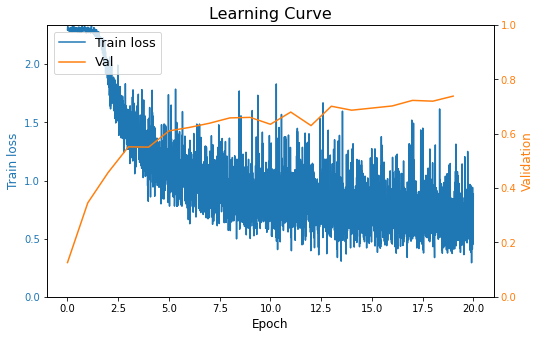

In [ ]:
# Train the GNN
model = GNN(in_channels=1)
model.to(device)
gnn1_mnist_results = train_nn(model, mnist_train_uniform, mnist_test_uniform, graph=True)
learning_curve(gnn1_mnist_results)

model = GNN(in_channels=3)
model.to(device)
gnn2_mnist_results = train_nn(model, mnist_train_uniform_pe, mnist_test_uniform_pe, graph=True)
learning_curve(gnn2_mnist_results)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

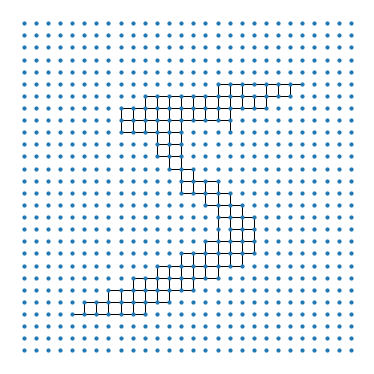

In [ ]:
def structured_edge_matrix(x):
    # FIXME: Create an adjacency matrix for a structured grid

    W = x.shape[1]
    
    grid_matrix = np.zeros((W*W, W*W))
    for i in range(W):
        for j in range(W):
            if(i>=1) and x[0][i,j]>0.4 and x[0][(i-1),j] >0.4:
                grid_matrix[i*W+j, (i-1)*W+j] = 1
            if i>=2 and x[0][i,j]>0.4 and x[0][(i-2),j] >0.4:
                grid_matrix[i*W+j, (i-2)*W+j] = 1
            if(i<W-1) and x[0][i,j]>0.4 and x[0][(i+1),j] >0.4:
                grid_matrix[i*W+j, (i+1)*W+j] = 1
            if(i<W-2) and x[0][i,j]>0.4 and x[0][(i+2),j] >0.4:
                grid_matrix[i*W+j, (i+2)*W+j] = 1
  
            if(j>=1)and x[0][i,j]>0.4 and x[0][(i),(j-1)] >0.4:
                grid_matrix[i*W+j, (i)*W+(j-1)] = 1
            if(j<W-1) and x[0][i,j]>0.4 and x[0][(i),(j+1)] >0.4:
                grid_matrix[i*W+j, (i)*W+(j+1)] = 1
            if(j>=2) and x[0][i,j]>0.4 and x[0][(i),(j-2)] >0.4:
                grid_matrix[i*W+j, (i)*W+(j-2)] = 1
            if(j<W-2) and x[0][i,j]>0.4 and x[0][(i),(j+2)] >0.4:
                grid_matrix[i*W+j, (i)*W+(j+2)] = 1
    return grid_matrix




# Verify your implementation before converting the entire dataset.
plot_adjacency_matrix(structured_edge_matrix(mnist_train[0][0]))



In [ ]:
# These may take some time, but it shouldn't be more than a few minutes.
mnist_train_structured = tograph(mnist_train, structured_edge_matrix, position_encoding=False)
mnist_test_structured = tograph(mnist_test, structured_edge_matrix, position_encoding=False)

mnist_train_structured_pe = tograph(mnist_train, structured_edge_matrix, position_encoding=True)
mnist_test_structured_pe = tograph(mnist_test, structured_edge_matrix, position_encoding=True)

100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


100%|██████████| 188/188 [00:01<00:00, 127.64it/s]


Epoch 0: Train Loss=2.3025671142212887 Validation Accuracy=9.66796875%


100%|██████████| 188/188 [00:01<00:00, 127.73it/s]


Epoch 1: Train Loss=2.3132664414890862 Validation Accuracy=9.66796875%


100%|██████████| 188/188 [00:01<00:00, 129.80it/s]


Epoch 2: Train Loss=2.3131172513563625 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 128.99it/s]


Epoch 3: Train Loss=2.3132061691231334 Validation Accuracy=13.0859375%


100%|██████████| 188/188 [00:01<00:00, 131.51it/s]


Epoch 4: Train Loss=2.3127323831497075 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 131.36it/s]


Epoch 5: Train Loss=2.312836805157933 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 131.22it/s]


Epoch 6: Train Loss=2.3126519039123883 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 128.25it/s]


Epoch 7: Train Loss=2.3127991419284744 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 130.35it/s]


Epoch 8: Train Loss=2.312593012023717 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 131.02it/s]


Epoch 9: Train Loss=2.3123822442023085 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 129.00it/s]


Epoch 10: Train Loss=2.3123258188638114 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 128.92it/s]


Epoch 11: Train Loss=2.312111382067665 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 129.29it/s]


Epoch 12: Train Loss=2.3122414312695594 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 128.40it/s]


Epoch 13: Train Loss=2.3114820407859056 Validation Accuracy=11.42578125%


100%|██████████| 188/188 [00:01<00:00, 131.02it/s]


Epoch 14: Train Loss=2.3113576863288836 Validation Accuracy=12.59765625%


100%|██████████| 188/188 [00:01<00:00, 128.91it/s]


Epoch 15: Train Loss=2.3101118876441995 Validation Accuracy=11.42578125%


100%|██████████| 188/188 [00:01<00:00, 127.03it/s]


Epoch 16: Train Loss=2.3087983442504276 Validation Accuracy=11.81640625%


100%|██████████| 188/188 [00:01<00:00, 128.87it/s]


Epoch 17: Train Loss=2.3055727267905537 Validation Accuracy=13.8671875%


100%|██████████| 188/188 [00:01<00:00, 130.34it/s]


Epoch 18: Train Loss=2.298450118569958 Validation Accuracy=14.74609375%


100%|██████████| 188/188 [00:01<00:00, 129.97it/s]


Epoch 19: Train Loss=2.2858375964343782 Validation Accuracy=13.18359375%


100%|██████████| 188/188 [00:01<00:00, 121.55it/s]


Epoch 0: Train Loss=2.3035468826902674 Validation Accuracy=10.7421875%


100%|██████████| 188/188 [00:01<00:00, 128.39it/s]


Epoch 1: Train Loss=2.301625656199272 Validation Accuracy=17.48046875%


100%|██████████| 188/188 [00:01<00:00, 126.35it/s]


Epoch 2: Train Loss=2.1337807447305375 Validation Accuracy=33.984375%


100%|██████████| 188/188 [00:01<00:00, 128.96it/s]


Epoch 3: Train Loss=1.6775534991415844 Validation Accuracy=48.92578125%


100%|██████████| 188/188 [00:02<00:00, 92.76it/s] 


Epoch 4: Train Loss=1.3390699870429947 Validation Accuracy=55.56640625%


100%|██████████| 188/188 [00:01<00:00, 130.86it/s]


Epoch 5: Train Loss=1.1934320027561065 Validation Accuracy=56.25%


100%|██████████| 188/188 [00:01<00:00, 129.05it/s]


Epoch 6: Train Loss=1.0928672281007665 Validation Accuracy=60.64453125%


100%|██████████| 188/188 [00:01<00:00, 129.34it/s]


Epoch 7: Train Loss=1.0471315407832784 Validation Accuracy=60.3515625%


100%|██████████| 188/188 [00:01<00:00, 130.66it/s]


Epoch 8: Train Loss=1.0090988557516685 Validation Accuracy=62.6953125%


100%|██████████| 188/188 [00:01<00:00, 131.13it/s]


Epoch 9: Train Loss=0.9711298541402241 Validation Accuracy=66.11328125%


100%|██████████| 188/188 [00:01<00:00, 130.54it/s]


Epoch 10: Train Loss=0.9443687255480693 Validation Accuracy=64.2578125%


100%|██████████| 188/188 [00:01<00:00, 129.45it/s]


Epoch 11: Train Loss=0.925676804936999 Validation Accuracy=63.96484375%


100%|██████████| 188/188 [00:01<00:00, 130.04it/s]


Epoch 12: Train Loss=0.9028211222375383 Validation Accuracy=64.453125%


100%|██████████| 188/188 [00:01<00:00, 130.00it/s]


Epoch 13: Train Loss=0.8866656092814756 Validation Accuracy=66.6015625%


100%|██████████| 188/188 [00:01<00:00, 129.76it/s]


Epoch 14: Train Loss=0.8648611868146527 Validation Accuracy=67.28515625%


100%|██████████| 188/188 [00:01<00:00, 129.03it/s]


Epoch 15: Train Loss=0.8540549266976264 Validation Accuracy=67.7734375%


100%|██████████| 188/188 [00:01<00:00, 130.78it/s]


Epoch 16: Train Loss=0.8312808940959328 Validation Accuracy=67.28515625%


100%|██████████| 188/188 [00:01<00:00, 129.49it/s]


Epoch 17: Train Loss=0.8241473794988243 Validation Accuracy=68.359375%


100%|██████████| 188/188 [00:01<00:00, 126.25it/s]


Epoch 18: Train Loss=0.8004076791892931 Validation Accuracy=68.9453125%


100%|██████████| 188/188 [00:01<00:00, 126.28it/s]


Epoch 19: Train Loss=0.8010158101364073 Validation Accuracy=68.65234375%


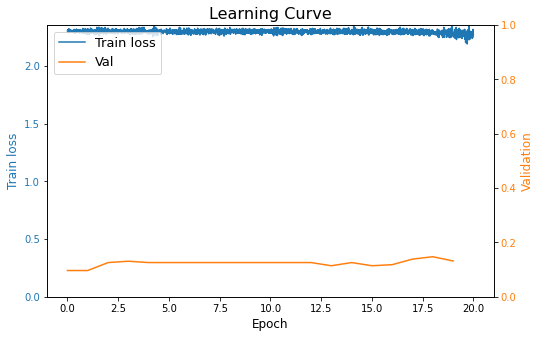

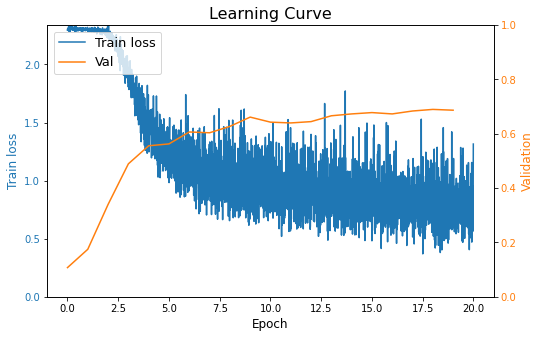

In [ ]:
# Train the GNN
model = GNN(in_channels=1)
model.to(device)
gnn3_mnist_results = train_nn(model, mnist_train_structured, mnist_test_structured, graph=True)
learning_curve(gnn3_mnist_results)

model = GNN(in_channels=3)
model.to(device)
gnn4_mnist_results = train_nn(model, mnist_train_structured_pe, mnist_test_structured_pe, graph=True)
learning_curve(gnn4_mnist_results)

## Architecture Comparison


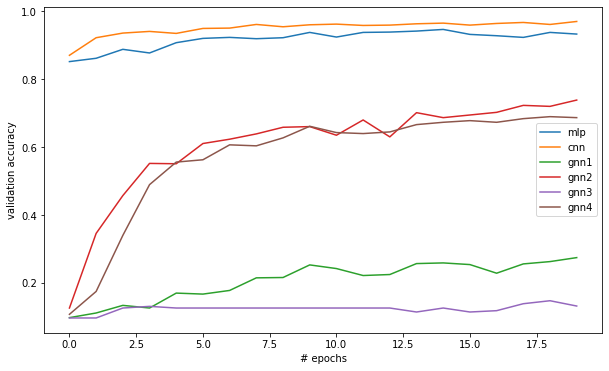

In [ ]:

plt.figure(figsize = (10,6))
plt.plot(mlp_mnist_results.val_accs,label = 'mlp')
plt.plot(cnn_mnist_results.val_accs,label = 'cnn')
plt.plot(gnn1_mnist_results.val_accs,label = 'gnn1')
plt.plot(gnn2_mnist_results.val_accs,label = 'gnn2')
plt.plot(gnn3_mnist_results.val_accs,label = 'gnn3')
plt.plot(gnn4_mnist_results.val_accs,label = 'gnn4')
plt.legend()
plt.xlabel('# epochs')
plt.ylabel('validation accuracy')
plt.show()

# Molecules



Molecules can be represented in a graph structure in which the nodes are atoms and the edges are bonds between atoms or as an image in the form of a SMILES line notation. Both representations have the same information.



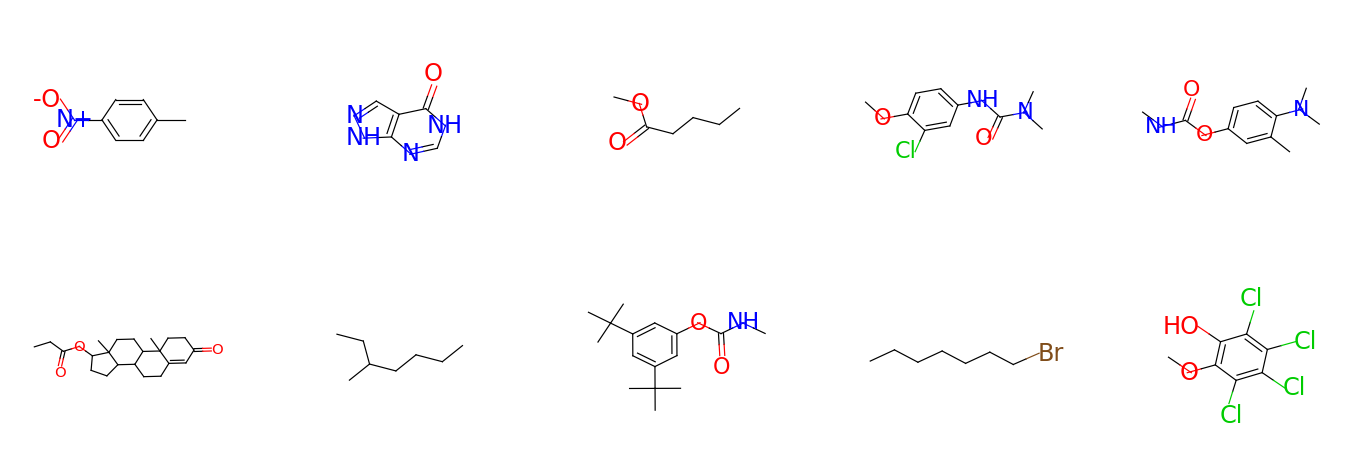

In [ ]:

!pip install torchdrug

from torch_geometric.datasets import MoleculeNet
from torchdrug import data as tddata
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from IPython.display import clear_output

dataset = MoleculeNet(root='/tmp/ESOL', name='ESOL')
dataset = dataset.shuffle()

graph_dataset = []
image_dataset = []
data_els = []
for data_el in tqdm(dataset):
    try:
        mol = tddata.Molecule.from_smiles(data_el.smiles)
    except:
        continue
    fig = Figure(figsize=(2, 2))
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    ax.axis('off')
    p = mol.visualize(ax=ax)
    canvas.draw()       # draw the canvas, cache the renderer

    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    plt.cla()
    plt.close("all")
    if(data_el.x.shape[0]>0):
        image_dataset.append((torch.tensor(image_from_plot).type(torch.FloatTensor).permute(2, 0, 1), torch.squeeze(data_el.y)))
        graph_dataset.append(Data(x=data_el.x.type(torch.FloatTensor), edge_index=data_el.edge_index, edge_attr=data_el.edge_attr, smiles=data_el.smiles, y=data_el.y))
        data_els.append(data_el)
    
num_train = 2*len(graph_dataset)//3

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchdrug-0.2.0.post1-py3-none-any.whl (267 kB)
  Using cached rdkit_pypi-2022.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.8 MB)
  Using cached ninja-1.10.2.4-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (120 kB)
  Using cached fair_esm-1.0.3-py3-none-any.whl (76 kB)


Processing...
Done!
100%|██████████| 1128/1128 [02:19<00:00,  8.08it/s]


In [ ]:
num_train = 2*len(graph_dataset)//3

train_dataset_tox = graph_dataset[:num_train]
test_dataset_tox = graph_dataset[num_train:]

model = GNN(in_channels=9, out_channels=1).to(device)
gnn_molecule_results = train_nn(model, train_dataset_tox, test_dataset_tox, graph=True, regression=True, lr=5e-4, criterion=nn.MSELoss(), num_epochs=100)
learning_curve(gnn_molecule_results)

100%|██████████| 24/24 [00:03<00:00,  6.41it/s]


Epoch 0: Train Loss=11.937821785608927 Validation Loss=10.298439304033915


100%|██████████| 24/24 [00:00<00:00, 66.72it/s]


Epoch 1: Train Loss=7.839697496758567 Validation Loss=4.423262516657512


100%|██████████| 24/24 [00:00<00:00, 30.35it/s]


Epoch 2: Train Loss=5.0863094386403205 Validation Loss=4.523910423119863


100%|██████████| 24/24 [00:00<00:00, 31.24it/s]


Epoch 3: Train Loss=4.805341532068717 Validation Loss=4.317974766095479


100%|██████████| 24/24 [00:00<00:00, 134.88it/s]


Epoch 4: Train Loss=4.661203287137766 Validation Loss=4.301984926064809


100%|██████████| 24/24 [00:00<00:00, 130.21it/s]


Epoch 5: Train Loss=4.616456892014097 Validation Loss=4.348364969094594


100%|██████████| 24/24 [00:00<00:00, 104.31it/s]


Epoch 6: Train Loss=4.693315104722999 Validation Loss=4.242829501628876


100%|██████████| 24/24 [00:00<00:00, 48.14it/s]


Epoch 7: Train Loss=4.5847987365424645 Validation Loss=4.211427211761475


100%|██████████| 24/24 [00:00<00:00, 57.11it/s]


Epoch 8: Train Loss=4.5292844045149785 Validation Loss=4.198759953180949


100%|██████████| 24/24 [00:00<00:00, 46.22it/s]


Epoch 9: Train Loss=4.515202280829299 Validation Loss=4.154071966807048


100%|██████████| 24/24 [00:00<00:00, 91.79it/s] 


Epoch 10: Train Loss=4.465925445033029 Validation Loss=4.1139018932978315


100%|██████████| 24/24 [00:00<00:00, 42.27it/s]


Epoch 11: Train Loss=4.410717258431553 Validation Loss=4.070628881454468


100%|██████████| 24/24 [00:00<00:00, 68.59it/s]


Epoch 12: Train Loss=4.427659074861889 Validation Loss=4.064114073912303


100%|██████████| 24/24 [00:00<00:00, 52.02it/s]


Epoch 13: Train Loss=4.3438772377205845 Validation Loss=3.9793684085210166


100%|██████████| 24/24 [00:00<00:00, 92.28it/s]


Epoch 14: Train Loss=4.273853467640087 Validation Loss=3.939150313536326


100%|██████████| 24/24 [00:00<00:00, 131.42it/s]


Epoch 15: Train Loss=4.219799992389845 Validation Loss=3.912633736928304


100%|██████████| 24/24 [00:00<00:00, 138.97it/s]


Epoch 16: Train Loss=4.1933398096489976 Validation Loss=3.857138286034266


100%|██████████| 24/24 [00:00<00:00, 139.32it/s]


Epoch 17: Train Loss=4.207447826236188 Validation Loss=3.823679248491923


100%|██████████| 24/24 [00:00<00:00, 138.23it/s]


Epoch 18: Train Loss=4.205715668672062 Validation Loss=3.798894772926966


100%|██████████| 24/24 [00:00<00:00, 134.50it/s]


Epoch 19: Train Loss=4.128684471567213 Validation Loss=3.775595227877299


100%|██████████| 24/24 [00:00<00:00, 141.56it/s]


Epoch 20: Train Loss=4.150154017347417 Validation Loss=3.7503979206085205


100%|██████████| 24/24 [00:00<00:00, 136.31it/s]


Epoch 21: Train Loss=4.03678004538592 Validation Loss=3.7292648454507193


100%|██████████| 24/24 [00:00<00:00, 133.76it/s]


Epoch 22: Train Loss=4.040516323759976 Validation Loss=3.832589199145635


100%|██████████| 24/24 [00:00<00:00, 139.86it/s]


Epoch 23: Train Loss=4.034206288842477 Validation Loss=3.699100067218145


100%|██████████| 24/24 [00:00<00:00, 136.47it/s]


Epoch 24: Train Loss=3.973629231990548 Validation Loss=3.692928433418274


100%|██████████| 24/24 [00:00<00:00, 139.16it/s]


Epoch 25: Train Loss=3.956746438962766 Validation Loss=3.675467312335968


100%|██████████| 24/24 [00:00<00:00, 139.67it/s]


Epoch 26: Train Loss=3.9556593340230712 Validation Loss=3.671325663725535


100%|██████████| 24/24 [00:00<00:00, 140.52it/s]


Epoch 27: Train Loss=3.930567262245519 Validation Loss=3.7152795096238456


100%|██████████| 24/24 [00:00<00:00, 128.60it/s]


Epoch 28: Train Loss=4.000494072738344 Validation Loss=3.7219093243281045


100%|██████████| 24/24 [00:00<00:00, 131.03it/s]


Epoch 29: Train Loss=3.957236660433439 Validation Loss=3.7124910851319632


100%|██████████| 24/24 [00:00<00:00, 130.17it/s]


Epoch 30: Train Loss=3.94102696631156 Validation Loss=3.64571683605512


100%|██████████| 24/24 [00:00<00:00, 133.01it/s]


Epoch 31: Train Loss=3.9202199297041544 Validation Loss=3.639549672603607


100%|██████████| 24/24 [00:00<00:00, 124.15it/s]


Epoch 32: Train Loss=3.9187333398266424 Validation Loss=3.598492125670115


100%|██████████| 24/24 [00:00<00:00, 131.76it/s]


Epoch 33: Train Loss=3.8889044714189396 Validation Loss=3.6454281310240426


100%|██████████| 24/24 [00:00<00:00, 136.01it/s]


Epoch 34: Train Loss=3.9151091831931506 Validation Loss=3.6768427093823752


100%|██████████| 24/24 [00:00<00:00, 128.54it/s]


Epoch 35: Train Loss=3.9230621666461603 Validation Loss=3.586721102396647


100%|██████████| 24/24 [00:00<00:00, 121.44it/s]


Epoch 36: Train Loss=3.8102207018714416 Validation Loss=3.572981894016266


100%|██████████| 24/24 [00:00<00:00, 131.68it/s]


Epoch 37: Train Loss=3.8021280212277393 Validation Loss=3.567939519882202


100%|██████████| 24/24 [00:00<00:00, 129.91it/s]


Epoch 38: Train Loss=3.8098245538070556 Validation Loss=3.5886213382085166


100%|██████████| 24/24 [00:00<00:00, 140.95it/s]


Epoch 39: Train Loss=3.8056148525608697 Validation Loss=3.5404800474643707


100%|██████████| 24/24 [00:00<00:00, 125.40it/s]


Epoch 40: Train Loss=3.7765123257890885 Validation Loss=3.5342277884483337


100%|██████████| 24/24 [00:00<00:00, 134.57it/s]


Epoch 41: Train Loss=3.76307799174494 Validation Loss=3.6143553058306375


100%|██████████| 24/24 [00:00<00:00, 142.46it/s]


Epoch 42: Train Loss=3.7069954134333902 Validation Loss=3.5249062279860177


100%|██████████| 24/24 [00:00<00:00, 138.77it/s]


Epoch 43: Train Loss=3.728940096403612 Validation Loss=3.456321765979131


100%|██████████| 24/24 [00:00<00:00, 129.54it/s]


Epoch 44: Train Loss=3.6825955546111473 Validation Loss=3.43687105178833


100%|██████████| 24/24 [00:00<00:00, 130.07it/s]


Epoch 45: Train Loss=3.684747360796608 Validation Loss=3.6305708587169647


100%|██████████| 24/24 [00:00<00:00, 131.24it/s]


Epoch 46: Train Loss=3.8126600841122733 Validation Loss=3.5398358007272086


100%|██████████| 24/24 [00:00<00:00, 128.08it/s]


Epoch 47: Train Loss=3.663420780911371 Validation Loss=3.3929577569166818


100%|██████████| 24/24 [00:00<00:00, 133.63it/s]


Epoch 48: Train Loss=3.6612398270275164 Validation Loss=3.3786468307177224


100%|██████████| 24/24 [00:00<00:00, 133.50it/s]


Epoch 49: Train Loss=3.6382840757713795 Validation Loss=3.385663459698359


100%|██████████| 24/24 [00:00<00:00, 124.69it/s]


Epoch 50: Train Loss=3.6527584041371366 Validation Loss=3.443214257558187


100%|██████████| 24/24 [00:00<00:00, 134.06it/s]


Epoch 51: Train Loss=3.564382803296109 Validation Loss=3.335113048553467


100%|██████████| 24/24 [00:00<00:00, 131.34it/s]


Epoch 52: Train Loss=3.6068792596399395 Validation Loss=3.2959228654702506


100%|██████████| 24/24 [00:00<00:00, 133.78it/s]


Epoch 53: Train Loss=3.6793864131592198 Validation Loss=3.30333544810613


100%|██████████| 24/24 [00:00<00:00, 136.04it/s]


Epoch 54: Train Loss=3.58099137395878 Validation Loss=3.263308733701706


100%|██████████| 24/24 [00:00<00:00, 132.31it/s]


Epoch 55: Train Loss=3.457270750838129 Validation Loss=3.3164300123850503


100%|██████████| 24/24 [00:00<00:00, 133.35it/s]


Epoch 56: Train Loss=3.475904629025095 Validation Loss=3.293956180413564


100%|██████████| 24/24 [00:00<00:00, 129.34it/s]


Epoch 57: Train Loss=3.5005077887489247 Validation Loss=3.1818690299987793


100%|██████████| 24/24 [00:00<00:00, 136.64it/s]


Epoch 58: Train Loss=3.435486364567089 Validation Loss=3.2431053121884665


100%|██████████| 24/24 [00:00<00:00, 135.04it/s]


Epoch 59: Train Loss=3.409483146675916 Validation Loss=3.2356290221214294


100%|██████████| 24/24 [00:00<00:00, 125.87it/s]


Epoch 60: Train Loss=3.3118564764662124 Validation Loss=3.1992243925730386


100%|██████████| 24/24 [00:00<00:00, 139.87it/s]


Epoch 61: Train Loss=3.36066048211523 Validation Loss=3.103365341822306


100%|██████████| 24/24 [00:00<00:00, 133.00it/s]


Epoch 62: Train Loss=3.264119085697113 Validation Loss=3.2834650377432504


100%|██████████| 24/24 [00:00<00:00, 133.16it/s]


Epoch 63: Train Loss=3.199034241215544 Validation Loss=3.233984410762787


100%|██████████| 24/24 [00:00<00:00, 60.53it/s]


Epoch 64: Train Loss=3.1516692103352875 Validation Loss=2.9852632582187653


100%|██████████| 24/24 [00:00<00:00, 30.47it/s]


Epoch 65: Train Loss=3.068118604775132 Validation Loss=2.974986662467321


100%|██████████| 24/24 [00:00<00:00, 37.97it/s]


Epoch 66: Train Loss=3.0732835793145767 Validation Loss=3.2142207423845925


100%|██████████| 24/24 [00:00<00:00, 35.81it/s]


Epoch 67: Train Loss=3.036550070939992 Validation Loss=3.008470227320989


100%|██████████| 24/24 [00:00<00:00, 67.60it/s]


Epoch 68: Train Loss=3.124683654395182 Validation Loss=2.9027241667111716


100%|██████████| 24/24 [00:00<00:00, 48.01it/s]


Epoch 69: Train Loss=3.0071677928205762 Validation Loss=3.1152207056681314


100%|██████████| 24/24 [00:00<00:00, 135.11it/s]


Epoch 70: Train Loss=3.1520933350135736 Validation Loss=3.2024430433909097


100%|██████████| 24/24 [00:00<00:00, 128.60it/s]


Epoch 71: Train Loss=3.1482816307089805 Validation Loss=2.8501206239064536


100%|██████████| 24/24 [00:00<00:00, 132.01it/s]


Epoch 72: Train Loss=2.909493071206502 Validation Loss=2.995849589506785


100%|██████████| 24/24 [00:00<00:00, 80.38it/s]


Epoch 73: Train Loss=2.9092464588734877 Validation Loss=2.7702756524086


100%|██████████| 24/24 [00:00<00:00, 72.72it/s]


Epoch 74: Train Loss=2.843954603467772 Validation Loss=2.943160672982534


100%|██████████| 24/24 [00:00<00:00, 62.51it/s]


Epoch 75: Train Loss=2.8519047813529106 Validation Loss=2.815248270829519


100%|██████████| 24/24 [00:00<00:00, 64.78it/s]


Epoch 76: Train Loss=3.0487325005933408 Validation Loss=2.987054318189621


100%|██████████| 24/24 [00:00<00:00, 84.44it/s]


Epoch 77: Train Loss=2.9467074962672455 Validation Loss=2.7347603837649026


100%|██████████| 24/24 [00:00<00:00, 61.16it/s]


Epoch 78: Train Loss=2.7981228832247225 Validation Loss=3.0120321909586587


100%|██████████| 24/24 [00:00<00:00, 66.13it/s]


Epoch 79: Train Loss=2.788817216968546 Validation Loss=2.786983529726664


100%|██████████| 24/24 [00:00<00:00, 71.55it/s]


Epoch 80: Train Loss=2.7861899952928226 Validation Loss=2.691028048594793


100%|██████████| 24/24 [00:00<00:00, 120.35it/s]


Epoch 81: Train Loss=2.8073846781454157 Validation Loss=2.666188488403956


100%|██████████| 24/24 [00:00<00:00, 126.51it/s]


Epoch 82: Train Loss=2.6964692253379425 Validation Loss=2.66950852672259


100%|██████████| 24/24 [00:00<00:00, 132.09it/s]


Epoch 83: Train Loss=2.703476510025182 Validation Loss=2.703543613354365


100%|██████████| 24/24 [00:00<00:00, 77.03it/s]


Epoch 84: Train Loss=2.747876945534395 Validation Loss=2.6214326520760856


100%|██████████| 24/24 [00:00<00:00, 107.51it/s]


Epoch 85: Train Loss=2.7053884741084047 Validation Loss=2.602265556653341


100%|██████████| 24/24 [00:00<00:00, 94.49it/s]


Epoch 86: Train Loss=2.7328661699941432 Validation Loss=2.7921236554781594


100%|██████████| 24/24 [00:00<00:00, 54.99it/s]


Epoch 87: Train Loss=2.739360287867696 Validation Loss=2.7340775628884635


100%|██████████| 24/24 [00:00<00:00, 58.05it/s]


Epoch 88: Train Loss=2.629748580980744 Validation Loss=2.589136004447937


100%|██████████| 24/24 [00:00<00:00, 68.79it/s]


Epoch 89: Train Loss=2.6341361402690597 Validation Loss=2.7602653205394745


100%|██████████| 24/24 [00:00<00:00, 60.95it/s]


Epoch 90: Train Loss=2.685420585172128 Validation Loss=2.7794509331385293


100%|██████████| 24/24 [00:00<00:00, 86.33it/s]


Epoch 91: Train Loss=2.667997750660477 Validation Loss=2.741452078024546


100%|██████████| 24/24 [00:00<00:00, 122.03it/s]


Epoch 92: Train Loss=2.6859801673649373 Validation Loss=2.561124712228775


100%|██████████| 24/24 [00:00<00:00, 60.70it/s]


Epoch 93: Train Loss=2.6189844197024845 Validation Loss=2.5362901985645294


100%|██████████| 24/24 [00:00<00:00, 62.63it/s]


Epoch 94: Train Loss=2.5310498756914916 Validation Loss=2.713101247946421


100%|██████████| 24/24 [00:00<00:00, 78.88it/s]


Epoch 95: Train Loss=2.5609031033298604 Validation Loss=2.480913649002711


100%|██████████| 24/24 [00:00<00:00, 134.20it/s]


Epoch 96: Train Loss=2.5098884515951956 Validation Loss=2.575897693634033


100%|██████████| 24/24 [00:00<00:00, 132.75it/s]


Epoch 97: Train Loss=2.597218092998659 Validation Loss=2.49416047334671


100%|██████████| 24/24 [00:00<00:00, 131.19it/s]


Epoch 98: Train Loss=2.471846324566371 Validation Loss=2.512625207503637


100%|██████████| 24/24 [00:00<00:00, 135.88it/s]


Epoch 99: Train Loss=2.557906472946346 Validation Loss=2.4184789458910623


In [ ]:
train_dataset_tox = image_dataset[:num_train]
test_dataset_tox = image_dataset[num_train:]

model = CNN(in_channels=3, out_channels=1,image_size=144).to(device)
cnn_molecule_results = train_nn(model, train_dataset_tox, test_dataset_tox, lr=5e-5,  regression=True, criterion=nn.MSELoss(), num_epochs=100)
learning_curve(cnn_molecule_results)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 88%|████████▊ | 21/24 [00:05<00:00,  7.91it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 24/24 [00:05<00:00,  4.47it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])).

Epoch 0: Train Loss=2593.9509270985923 Validation Loss=73.44333585103352


100%|██████████| 24/24 [00:00<00:00, 80.11it/s]


Epoch 1: Train Loss=182.87784351242917 Validation Loss=67.07303587595622


100%|██████████| 24/24 [00:00<00:00, 85.79it/s]


Epoch 2: Train Loss=43.13216017241831 Validation Loss=30.438154538472492


100%|██████████| 24/24 [00:00<00:00, 84.89it/s]


Epoch 3: Train Loss=29.179280002313998 Validation Loss=26.450617631276447


100%|██████████| 24/24 [00:00<00:00, 84.79it/s]


Epoch 4: Train Loss=26.668795057444033 Validation Loss=25.76805027325948


100%|██████████| 24/24 [00:00<00:00, 86.05it/s]


Epoch 5: Train Loss=26.105573910321965 Validation Loss=25.057746807734173


100%|██████████| 24/24 [00:00<00:00, 84.84it/s]


Epoch 6: Train Loss=25.16232380344827 Validation Loss=24.492536544799805


100%|██████████| 24/24 [00:00<00:00, 85.40it/s]


Epoch 7: Train Loss=24.23576370257237 Validation Loss=23.772095998128254


100%|██████████| 24/24 [00:00<00:00, 84.98it/s]


Epoch 8: Train Loss=23.79953694980099 Validation Loss=23.160585800806682


100%|██████████| 24/24 [00:00<00:00, 66.86it/s]


Epoch 9: Train Loss=22.877442727751514 Validation Loss=22.556659698486328


100%|██████████| 24/24 [00:00<00:00, 72.42it/s]


Epoch 10: Train Loss=22.34102516912201 Validation Loss=22.233285744984943


100%|██████████| 24/24 [00:00<00:00, 73.07it/s]


Epoch 11: Train Loss=21.561832698493692 Validation Loss=21.489338239034016


100%|██████████| 24/24 [00:00<00:00, 69.16it/s]


Epoch 12: Train Loss=20.77454472715281 Validation Loss=20.97965629895528


100%|██████████| 24/24 [00:00<00:00, 84.96it/s]


Epoch 13: Train Loss=20.45477469809131 Validation Loss=20.669392347335815


100%|██████████| 24/24 [00:00<00:00, 85.51it/s]


Epoch 14: Train Loss=19.672773593021464 Validation Loss=20.112273931503296


100%|██████████| 24/24 [00:00<00:00, 82.08it/s]


Epoch 15: Train Loss=19.35525875262722 Validation Loss=19.575121879577637


100%|██████████| 24/24 [00:00<00:00, 74.28it/s]


Epoch 16: Train Loss=18.39334598389446 Validation Loss=19.174365599950153


100%|██████████| 24/24 [00:00<00:00, 78.29it/s]


Epoch 17: Train Loss=17.986000504430457 Validation Loss=18.803522030512493


100%|██████████| 24/24 [00:00<00:00, 74.99it/s]


Epoch 18: Train Loss=17.71871862669522 Validation Loss=18.533153772354126


100%|██████████| 24/24 [00:00<00:00, 84.70it/s]


Epoch 19: Train Loss=17.052837693798764 Validation Loss=17.96298869450887


100%|██████████| 24/24 [00:00<00:00, 84.79it/s]


Epoch 20: Train Loss=16.434674514834594 Validation Loss=17.68518050511678


100%|██████████| 24/24 [00:00<00:00, 85.54it/s]


Epoch 21: Train Loss=16.078168442410913 Validation Loss=17.307838280995686


100%|██████████| 24/24 [00:00<00:00, 83.26it/s]


Epoch 22: Train Loss=15.752501112328746 Validation Loss=17.017001310984295


100%|██████████| 24/24 [00:00<00:00, 84.66it/s]


Epoch 23: Train Loss=15.757169469450362 Validation Loss=16.872447808583576


100%|██████████| 24/24 [00:00<00:00, 85.34it/s]


Epoch 24: Train Loss=15.404108990573818 Validation Loss=16.728188514709473


100%|██████████| 24/24 [00:00<00:00, 82.97it/s]


Epoch 25: Train Loss=14.72369448299805 Validation Loss=16.255033413569134


100%|██████████| 24/24 [00:00<00:00, 85.39it/s]


Epoch 26: Train Loss=14.437031414755351 Validation Loss=15.988240718841553


100%|██████████| 24/24 [00:00<00:00, 79.67it/s]


Epoch 27: Train Loss=14.30470381787453 Validation Loss=15.927030007044474


100%|██████████| 24/24 [00:00<00:00, 68.52it/s]


Epoch 28: Train Loss=13.860985124529662 Validation Loss=16.01206103960673


100%|██████████| 24/24 [00:00<00:00, 41.56it/s]


Epoch 29: Train Loss=13.934513900198093 Validation Loss=15.337153752644857


100%|██████████| 24/24 [00:00<00:00, 73.45it/s]


Epoch 30: Train Loss=13.954211924370691 Validation Loss=15.40142035484314


100%|██████████| 24/24 [00:00<00:00, 80.65it/s]


Epoch 31: Train Loss=13.395677476040879 Validation Loss=14.980632702509562


100%|██████████| 24/24 [00:00<00:00, 83.04it/s]


Epoch 32: Train Loss=13.194106455847304 Validation Loss=14.803095579147339


100%|██████████| 24/24 [00:00<00:00, 63.14it/s]


Epoch 33: Train Loss=12.536509925963344 Validation Loss=14.669814745585123


100%|██████████| 24/24 [00:00<00:00, 70.13it/s]


Epoch 34: Train Loss=12.457734145010589 Validation Loss=14.642812172571817


100%|██████████| 24/24 [00:00<00:00, 77.59it/s]


Epoch 35: Train Loss=12.427664341085697 Validation Loss=14.426749467849731


100%|██████████| 24/24 [00:00<00:00, 84.04it/s]


Epoch 36: Train Loss=12.199525259499481 Validation Loss=14.353968779246012


100%|██████████| 24/24 [00:00<00:00, 85.41it/s]


Epoch 37: Train Loss=12.04420886033793 Validation Loss=14.13743805885315


100%|██████████| 24/24 [00:00<00:00, 84.05it/s]


Epoch 38: Train Loss=11.865914736188955 Validation Loss=13.984040021896362


100%|██████████| 24/24 [00:00<00:00, 84.16it/s]


Epoch 39: Train Loss=11.746055837886098 Validation Loss=13.86227822303772


100%|██████████| 24/24 [00:00<00:00, 85.13it/s]


Epoch 40: Train Loss=11.564760813962112 Validation Loss=13.769464095433554


100%|██████████| 24/24 [00:00<00:00, 83.80it/s]


Epoch 41: Train Loss=11.44190751056914 Validation Loss=13.64409613609314


100%|██████████| 24/24 [00:00<00:00, 84.31it/s]


Epoch 42: Train Loss=11.168481374176444 Validation Loss=13.597028811772665


100%|██████████| 24/24 [00:00<00:00, 85.13it/s]


Epoch 43: Train Loss=11.064334433293679 Validation Loss=13.518696943918863


100%|██████████| 24/24 [00:00<00:00, 84.32it/s]


Epoch 44: Train Loss=10.979851982701831 Validation Loss=13.501277287801107


100%|██████████| 24/24 [00:00<00:00, 84.70it/s]


Epoch 45: Train Loss=10.714598070486923 Validation Loss=13.28987447420756


100%|██████████| 24/24 [00:00<00:00, 83.73it/s]


Epoch 46: Train Loss=10.450600281809127 Validation Loss=13.247353871663412


100%|██████████| 24/24 [00:00<00:00, 85.69it/s]


Epoch 47: Train Loss=10.41731538935893 Validation Loss=13.195083697636923


100%|██████████| 24/24 [00:00<00:00, 84.07it/s]


Epoch 48: Train Loss=10.304896748133993 Validation Loss=13.061204512914022


100%|██████████| 24/24 [00:00<00:00, 84.61it/s]


Epoch 49: Train Loss=10.185789998871936 Validation Loss=13.035619894663492


100%|██████████| 24/24 [00:00<00:00, 83.94it/s]


Epoch 50: Train Loss=10.234956003580775 Validation Loss=12.912431875864664


100%|██████████| 24/24 [00:00<00:00, 84.79it/s]


Epoch 51: Train Loss=10.295290677802194 Validation Loss=12.918653090794882


100%|██████████| 24/24 [00:00<00:00, 85.51it/s]


Epoch 52: Train Loss=10.264949688027983 Validation Loss=13.341703176498413


100%|██████████| 24/24 [00:00<00:00, 85.63it/s]


Epoch 53: Train Loss=9.829303915662512 Validation Loss=12.997349500656128


100%|██████████| 24/24 [00:00<00:00, 83.70it/s]


Epoch 54: Train Loss=9.839693493949165 Validation Loss=12.682505051294962


100%|██████████| 24/24 [00:00<00:00, 84.62it/s]


Epoch 55: Train Loss=9.699577865803688 Validation Loss=12.688360373179117


100%|██████████| 24/24 [00:00<00:00, 84.89it/s]


Epoch 56: Train Loss=9.676292223144094 Validation Loss=12.8023202419281


100%|██████████| 24/24 [00:00<00:00, 83.38it/s]


Epoch 57: Train Loss=9.565483363237998 Validation Loss=12.905399481455484


100%|██████████| 24/24 [00:00<00:00, 84.52it/s]


Epoch 58: Train Loss=9.645518016143269 Validation Loss=12.497898976008097


100%|██████████| 24/24 [00:00<00:00, 83.54it/s]


Epoch 59: Train Loss=9.335188436480182 Validation Loss=12.396621068318685


100%|██████████| 24/24 [00:00<00:00, 84.25it/s]


Epoch 60: Train Loss=9.278986734150672 Validation Loss=12.463435649871826


100%|██████████| 24/24 [00:00<00:00, 84.88it/s]


Epoch 61: Train Loss=9.120263965676179 Validation Loss=12.341340065002441


100%|██████████| 24/24 [00:00<00:00, 85.14it/s]


Epoch 62: Train Loss=9.058901803019557 Validation Loss=12.302632967631022


100%|██████████| 24/24 [00:00<00:00, 85.65it/s]


Epoch 63: Train Loss=9.052777032733085 Validation Loss=12.259546836217245


100%|██████████| 24/24 [00:00<00:00, 84.38it/s]


Epoch 64: Train Loss=8.87699881116053 Validation Loss=12.193408489227295


100%|██████████| 24/24 [00:00<00:00, 84.38it/s]


Epoch 65: Train Loss=8.742925818976223 Validation Loss=12.120044310887655


100%|██████████| 24/24 [00:00<00:00, 84.66it/s]


Epoch 66: Train Loss=8.733499554139726 Validation Loss=12.093533992767334


100%|██████████| 24/24 [00:00<00:00, 85.03it/s]


Epoch 67: Train Loss=8.566082816460991 Validation Loss=12.018563350041708


100%|██████████| 24/24 [00:00<00:00, 84.67it/s]


Epoch 68: Train Loss=8.661565476868686 Validation Loss=11.986425240834555


100%|██████████| 24/24 [00:00<00:00, 82.30it/s]


Epoch 69: Train Loss=8.62965218947224 Validation Loss=11.96559190750122


100%|██████████| 24/24 [00:00<00:00, 84.87it/s]


Epoch 70: Train Loss=8.41889493363015 Validation Loss=11.924094200134277


100%|██████████| 24/24 [00:00<00:00, 83.68it/s]


Epoch 71: Train Loss=8.302812344786572 Validation Loss=11.980053027470907


100%|██████████| 24/24 [00:00<00:00, 84.36it/s]


Epoch 72: Train Loss=8.378662318279224 Validation Loss=11.869955142339071


100%|██████████| 24/24 [00:00<00:00, 84.13it/s]


Epoch 73: Train Loss=8.16488209243822 Validation Loss=12.109408537546793


100%|██████████| 24/24 [00:00<00:00, 85.25it/s]


Epoch 74: Train Loss=8.146249489186625 Validation Loss=11.78180988629659


100%|██████████| 24/24 [00:00<00:00, 84.14it/s]


Epoch 75: Train Loss=8.071814624642267 Validation Loss=11.756914774576822


100%|██████████| 24/24 [00:00<00:00, 83.89it/s]


Epoch 76: Train Loss=8.06040134397542 Validation Loss=11.810620466868082


100%|██████████| 24/24 [00:00<00:00, 83.28it/s]


Epoch 77: Train Loss=7.993769820517714 Validation Loss=11.776935577392578


100%|██████████| 24/24 [00:00<00:00, 84.50it/s]


Epoch 78: Train Loss=7.98371281954921 Validation Loss=11.701226711273193


100%|██████████| 24/24 [00:00<00:00, 83.40it/s]


Epoch 79: Train Loss=7.865777319807674 Validation Loss=11.754329284032186


100%|██████████| 24/24 [00:00<00:00, 84.37it/s]


Epoch 80: Train Loss=7.771447492396619 Validation Loss=11.611169497172037


100%|██████████| 24/24 [00:00<00:00, 85.35it/s]


Epoch 81: Train Loss=7.673605832488826 Validation Loss=11.582441091537476


100%|██████████| 24/24 [00:00<00:00, 85.48it/s]


Epoch 82: Train Loss=7.567364093041729 Validation Loss=11.58846116065979


100%|██████████| 24/24 [00:00<00:00, 84.74it/s]


Epoch 83: Train Loss=7.560746863334391 Validation Loss=11.556599934895834


100%|██████████| 24/24 [00:00<00:00, 83.30it/s]


Epoch 84: Train Loss=7.492758202670721 Validation Loss=11.71211306254069


100%|██████████| 24/24 [00:00<00:00, 83.98it/s]


Epoch 85: Train Loss=7.457098034029152 Validation Loss=11.915557781855265


100%|██████████| 24/24 [00:00<00:00, 85.03it/s]


Epoch 86: Train Loss=7.715971788888381 Validation Loss=11.519017775853476


100%|██████████| 24/24 [00:00<00:00, 84.88it/s]


Epoch 87: Train Loss=7.415279560665506 Validation Loss=11.464335997899374


100%|██████████| 24/24 [00:00<00:00, 83.67it/s]


Epoch 88: Train Loss=7.42574384532787 Validation Loss=11.513803243637085


100%|██████████| 24/24 [00:00<00:00, 82.85it/s]


Epoch 89: Train Loss=7.405562868847788 Validation Loss=11.84303069114685


100%|██████████| 24/24 [00:00<00:00, 83.93it/s]


Epoch 90: Train Loss=7.341829160482285 Validation Loss=11.479540824890137


100%|██████████| 24/24 [00:00<00:00, 80.55it/s]


Epoch 91: Train Loss=7.267826312930659 Validation Loss=11.786234219868978


100%|██████████| 24/24 [00:00<00:00, 81.78it/s]


Epoch 92: Train Loss=7.354087640599711 Validation Loss=11.524983565012613


100%|██████████| 24/24 [00:00<00:00, 81.99it/s]


Epoch 93: Train Loss=7.290738733682215 Validation Loss=11.351300875345865


100%|██████████| 24/24 [00:00<00:00, 79.88it/s]


Epoch 94: Train Loss=7.197484022713088 Validation Loss=11.34961986541748


100%|██████████| 24/24 [00:00<00:00, 80.15it/s]


Epoch 95: Train Loss=7.203148325546597 Validation Loss=11.336511452992758


100%|██████████| 24/24 [00:00<00:00, 79.44it/s]


Epoch 96: Train Loss=6.969528633698158 Validation Loss=11.322993516921997


100%|██████████| 24/24 [00:00<00:00, 79.16it/s]


Epoch 97: Train Loss=6.969515510662742 Validation Loss=11.296644687652588


100%|██████████| 24/24 [00:00<00:00, 85.20it/s]


Epoch 98: Train Loss=6.991314558033494 Validation Loss=11.632335424423218


100%|██████████| 24/24 [00:00<00:00, 85.12it/s]


Epoch 99: Train Loss=7.101443157752534 Validation Loss=11.461129983266195


In [ ]:
train_dataset_tox = image_dataset[:num_train]
test_dataset_tox = image_dataset[num_train:]

input_channels = np.prod(train_dataset_tox[0][0].shape)
model = MLP(in_channels = input_channels, out_channels=1).to(device)
mlp_molecule_results = train_nn(model, train_dataset_tox, test_dataset_tox, lr=5e-5,  regression=True, criterion=nn.MSELoss(), num_epochs=100)
learning_curve(mlp_molecule_results)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 12/24 [00:00<00:00, 117.29it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 24/24 [00:00<00:00, 125.93it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])

Epoch 0: Train Loss=12.344202558199564 Validation Loss=4.346384863058726


100%|██████████| 24/24 [00:00<00:00, 143.49it/s]


Epoch 1: Train Loss=5.847105653749572 Validation Loss=4.304736256599426


100%|██████████| 24/24 [00:00<00:00, 134.51it/s]


Epoch 2: Train Loss=5.658965732971275 Validation Loss=4.38089656829834


100%|██████████| 24/24 [00:00<00:00, 134.70it/s]


Epoch 3: Train Loss=4.8303575874335 Validation Loss=4.793401002883911


100%|██████████| 24/24 [00:00<00:00, 126.56it/s]


Epoch 4: Train Loss=5.214747579399771 Validation Loss=8.385441184043884


100%|██████████| 24/24 [00:00<00:00, 142.02it/s]


Epoch 5: Train Loss=6.479095048022934 Validation Loss=7.489485303560893


100%|██████████| 24/24 [00:00<00:00, 141.40it/s]


Epoch 6: Train Loss=6.318086865308909 Validation Loss=8.678993423779806


100%|██████████| 24/24 [00:00<00:00, 143.63it/s]


Epoch 7: Train Loss=5.931889742727207 Validation Loss=4.304019927978516


100%|██████████| 24/24 [00:00<00:00, 137.51it/s]


Epoch 8: Train Loss=5.637485502913393 Validation Loss=4.286545813083649


100%|██████████| 24/24 [00:00<00:00, 140.36it/s]


Epoch 9: Train Loss=5.501812477855004 Validation Loss=6.79912010828654


100%|██████████| 24/24 [00:00<00:00, 142.65it/s]


Epoch 10: Train Loss=5.537909001937678 Validation Loss=4.410092731316884


100%|██████████| 24/24 [00:00<00:00, 141.24it/s]


Epoch 11: Train Loss=5.219593096558881 Validation Loss=4.479960997899373


100%|██████████| 24/24 [00:00<00:00, 143.54it/s]


Epoch 12: Train Loss=4.940729779037528 Validation Loss=4.354859073956807


100%|██████████| 24/24 [00:00<00:00, 142.39it/s]


Epoch 13: Train Loss=5.103799012056353 Validation Loss=4.33147253592809


100%|██████████| 24/24 [00:00<00:00, 142.50it/s]


Epoch 14: Train Loss=5.7663980485147635 Validation Loss=4.454841276009877


100%|██████████| 24/24 [00:00<00:00, 140.78it/s]


Epoch 15: Train Loss=4.980999513471898 Validation Loss=4.294078330198924


100%|██████████| 24/24 [00:00<00:00, 143.40it/s]


Epoch 16: Train Loss=5.234517049624058 Validation Loss=4.45268851518631


100%|██████████| 24/24 [00:00<00:00, 135.28it/s]


Epoch 17: Train Loss=5.004496403528317 Validation Loss=4.282646755377452


100%|██████████| 24/24 [00:00<00:00, 137.87it/s]


Epoch 18: Train Loss=5.291460268530294 Validation Loss=4.406309902667999


100%|██████████| 24/24 [00:00<00:00, 136.80it/s]


Epoch 19: Train Loss=4.9937723872079225 Validation Loss=4.351969063282013


100%|██████████| 24/24 [00:00<00:00, 136.31it/s]


Epoch 20: Train Loss=5.374803458638546 Validation Loss=4.979398866494496


100%|██████████| 24/24 [00:00<00:00, 133.82it/s]


Epoch 21: Train Loss=5.165064967133418 Validation Loss=4.495249569416046


100%|██████████| 24/24 [00:00<00:00, 133.64it/s]


Epoch 22: Train Loss=4.847252007841146 Validation Loss=4.281007707118988


100%|██████████| 24/24 [00:00<00:00, 142.30it/s]


Epoch 23: Train Loss=4.924473260695698 Validation Loss=6.001926640669505


100%|██████████| 24/24 [00:00<00:00, 93.59it/s]


Epoch 24: Train Loss=5.275680014443686 Validation Loss=4.385905921459198


100%|██████████| 24/24 [00:00<00:00, 78.82it/s]


Epoch 25: Train Loss=5.1705344397554915 Validation Loss=4.659417788187663


100%|██████████| 24/24 [00:00<00:00, 126.07it/s]


Epoch 26: Train Loss=4.981240185924413 Validation Loss=5.510504523913066


100%|██████████| 24/24 [00:00<00:00, 140.92it/s]


Epoch 27: Train Loss=5.133734451103046 Validation Loss=4.282142559687297


100%|██████████| 24/24 [00:00<00:00, 135.89it/s]


Epoch 28: Train Loss=5.025913009476654 Validation Loss=4.507986048857371


100%|██████████| 24/24 [00:00<00:00, 136.33it/s]


Epoch 29: Train Loss=4.953520973913868 Validation Loss=4.772586067517598


100%|██████████| 24/24 [00:00<00:00, 144.61it/s]


Epoch 30: Train Loss=4.967872041811256 Validation Loss=4.504463215668996


100%|██████████| 24/24 [00:00<00:00, 135.73it/s]


Epoch 31: Train Loss=5.01611918783642 Validation Loss=4.398763716220856


100%|██████████| 24/24 [00:00<00:00, 121.01it/s]


Epoch 32: Train Loss=4.95158138646701 Validation Loss=4.533627927303314


100%|██████████| 24/24 [00:00<00:00, 96.14it/s]


Epoch 33: Train Loss=5.355300502137186 Validation Loss=4.334431807200114


100%|██████████| 24/24 [00:00<00:00, 96.33it/s]


Epoch 34: Train Loss=4.8833580197623965 Validation Loss=4.524972240130107


100%|██████████| 24/24 [00:00<00:00, 86.49it/s]


Epoch 35: Train Loss=5.687354078647708 Validation Loss=4.308849612871806


100%|██████████| 24/24 [00:00<00:00, 42.15it/s]


Epoch 36: Train Loss=4.985655704751495 Validation Loss=5.793708761533101


100%|██████████| 24/24 [00:00<00:00, 108.26it/s]


Epoch 37: Train Loss=5.298759755145133 Validation Loss=4.337239662806193


100%|██████████| 24/24 [00:00<00:00, 144.00it/s]


Epoch 38: Train Loss=4.98037510351384 Validation Loss=4.301304618517558


100%|██████████| 24/24 [00:00<00:00, 136.14it/s]


Epoch 39: Train Loss=4.84323306101728 Validation Loss=4.396640618642171


100%|██████████| 24/24 [00:00<00:00, 131.07it/s]


Epoch 40: Train Loss=4.793583013621539 Validation Loss=5.360837817192078


100%|██████████| 24/24 [00:00<00:00, 140.27it/s]


Epoch 41: Train Loss=5.187083864295134 Validation Loss=5.151366472244263


100%|██████████| 24/24 [00:00<00:00, 135.41it/s]


Epoch 42: Train Loss=5.272775914275135 Validation Loss=4.560646613438924


100%|██████████| 24/24 [00:00<00:00, 137.87it/s]


Epoch 43: Train Loss=5.405307979467987 Validation Loss=5.056539575258891


100%|██████████| 24/24 [00:00<00:00, 137.81it/s]


Epoch 44: Train Loss=5.574854968781416 Validation Loss=4.445896883805593


100%|██████████| 24/24 [00:00<00:00, 140.19it/s]


Epoch 45: Train Loss=4.974828566064236 Validation Loss=5.050335546334584


100%|██████████| 24/24 [00:00<00:00, 130.00it/s]


Epoch 46: Train Loss=4.858787500400916 Validation Loss=4.477988362312317


100%|██████████| 24/24 [00:00<00:00, 135.28it/s]


Epoch 47: Train Loss=4.81493129181943 Validation Loss=5.327772915363312


100%|██████████| 24/24 [00:00<00:00, 141.53it/s]


Epoch 48: Train Loss=4.86932277259234 Validation Loss=4.283038814862569


100%|██████████| 24/24 [00:00<00:00, 125.95it/s]


Epoch 49: Train Loss=4.8164651888844885 Validation Loss=4.4151016275087995


100%|██████████| 24/24 [00:00<00:00, 132.37it/s]


Epoch 50: Train Loss=4.811865500684569 Validation Loss=4.3516672650973005


100%|██████████| 24/24 [00:00<00:00, 139.71it/s]


Epoch 51: Train Loss=4.889530636042191 Validation Loss=4.355806628863017


100%|██████████| 24/24 [00:00<00:00, 139.34it/s]


Epoch 52: Train Loss=4.76867457136387 Validation Loss=4.640256841977437


100%|██████████| 24/24 [00:00<00:00, 144.84it/s]


Epoch 53: Train Loss=5.161137976540822 Validation Loss=4.946166535218556


100%|██████████| 24/24 [00:00<00:00, 142.81it/s]


Epoch 54: Train Loss=5.5593675639188005 Validation Loss=5.0528759360313416


100%|██████████| 24/24 [00:00<00:00, 140.17it/s]


Epoch 55: Train Loss=5.008525010057438 Validation Loss=4.571987013022105


100%|██████████| 24/24 [00:00<00:00, 46.42it/s]


Epoch 56: Train Loss=4.968473995564222 Validation Loss=4.287090361118317


100%|██████████| 24/24 [00:00<00:00, 62.56it/s]


Epoch 57: Train Loss=4.995446049705058 Validation Loss=4.488224347432454


100%|██████████| 24/24 [00:00<00:00, 56.07it/s]


Epoch 58: Train Loss=4.889014019052805 Validation Loss=4.732721785704295


100%|██████████| 24/24 [00:00<00:00, 58.11it/s]


Epoch 59: Train Loss=5.074277888299716 Validation Loss=4.340730627377828


100%|██████████| 24/24 [00:00<00:00, 35.53it/s]


Epoch 60: Train Loss=5.107144410848687 Validation Loss=4.55971626440684


100%|██████████| 24/24 [00:00<00:00, 43.18it/s]


Epoch 61: Train Loss=4.8569276455144115 Validation Loss=4.429217020670573


100%|██████████| 24/24 [00:00<00:00, 61.06it/s]


Epoch 62: Train Loss=5.043959558519639 Validation Loss=4.451111336549123


100%|██████████| 24/24 [00:00<00:00, 49.65it/s]


Epoch 63: Train Loss=4.779057788373403 Validation Loss=5.510496119658153


100%|██████████| 24/24 [00:00<00:00, 60.73it/s]


Epoch 64: Train Loss=4.7968970060150395 Validation Loss=4.414808372656505


100%|██████████| 24/24 [00:00<00:00, 42.99it/s]


Epoch 65: Train Loss=4.775314224758913 Validation Loss=4.280608594417572


100%|██████████| 24/24 [00:00<00:00, 138.40it/s]


Epoch 66: Train Loss=4.912954991600546 Validation Loss=4.451614121596019


100%|██████████| 24/24 [00:00<00:00, 133.54it/s]


Epoch 67: Train Loss=4.947109428774219 Validation Loss=4.280406554539998


100%|██████████| 24/24 [00:00<00:00, 143.17it/s]


Epoch 68: Train Loss=4.9112236486429515 Validation Loss=4.336252927780151


100%|██████████| 24/24 [00:00<00:00, 140.03it/s]


Epoch 69: Train Loss=5.120788882120428 Validation Loss=4.285904347896576


100%|██████████| 24/24 [00:00<00:00, 139.83it/s]


Epoch 70: Train Loss=5.751290165299507 Validation Loss=4.284384191036224


100%|██████████| 24/24 [00:00<00:00, 121.15it/s]


Epoch 71: Train Loss=4.940191828662916 Validation Loss=4.356182932853699


100%|██████████| 24/24 [00:00<00:00, 136.63it/s]


Epoch 72: Train Loss=5.262975477653028 Validation Loss=4.76985905567805


100%|██████████| 24/24 [00:00<00:00, 136.06it/s]


Epoch 73: Train Loss=5.331769288557987 Validation Loss=4.286913335323334


100%|██████████| 24/24 [00:00<00:00, 141.54it/s]


Epoch 74: Train Loss=4.962448539873718 Validation Loss=4.720319887002309


100%|██████████| 24/24 [00:00<00:00, 140.77it/s]


Epoch 75: Train Loss=5.2019387459813204 Validation Loss=4.473224957784017


100%|██████████| 24/24 [00:00<00:00, 132.94it/s]


Epoch 76: Train Loss=4.919378752410655 Validation Loss=4.379226227601369


100%|██████████| 24/24 [00:00<00:00, 132.56it/s]


Epoch 77: Train Loss=4.764749457227697 Validation Loss=4.40231317281723


100%|██████████| 24/24 [00:00<00:00, 142.65it/s]


Epoch 78: Train Loss=4.773088054929653 Validation Loss=4.350049992402394


100%|██████████| 24/24 [00:00<00:00, 139.51it/s]


Epoch 79: Train Loss=5.006633145820534 Validation Loss=4.368143379688263


100%|██████████| 24/24 [00:00<00:00, 122.08it/s]


Epoch 80: Train Loss=4.775631372432387 Validation Loss=5.368464946746826


100%|██████████| 24/24 [00:00<00:00, 85.79it/s] 


Epoch 81: Train Loss=5.117613750377482 Validation Loss=4.298615018526713


100%|██████████| 24/24 [00:00<00:00, 42.12it/s]


Epoch 82: Train Loss=4.757260966536038 Validation Loss=4.283349911371867


100%|██████████| 24/24 [00:00<00:00, 74.27it/s]


Epoch 83: Train Loss=4.777112739294628 Validation Loss=4.295888404051463


100%|██████████| 24/24 [00:00<00:00, 82.76it/s]


Epoch 84: Train Loss=4.845398327418908 Validation Loss=4.37754104534785


100%|██████████| 24/24 [00:00<00:00, 139.79it/s]


Epoch 85: Train Loss=4.734894718590244 Validation Loss=4.787953515847524


100%|██████████| 24/24 [00:00<00:00, 77.35it/s]


Epoch 86: Train Loss=4.782087503450731 Validation Loss=4.340992093086243


100%|██████████| 24/24 [00:00<00:00, 78.40it/s]


Epoch 87: Train Loss=4.844997771025433 Validation Loss=4.362881104151408


100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch 88: Train Loss=4.733074446827204 Validation Loss=4.445349295934041


100%|██████████| 24/24 [00:00<00:00, 57.10it/s]


Epoch 89: Train Loss=4.816790720667691 Validation Loss=4.551293293635051


100%|██████████| 24/24 [00:00<00:00, 55.89it/s]


Epoch 90: Train Loss=4.833045677213463 Validation Loss=4.886961241563161


100%|██████████| 24/24 [00:00<00:00, 54.14it/s]


Epoch 91: Train Loss=5.022019026836943 Validation Loss=6.72399361928304


100%|██████████| 24/24 [00:00<00:00, 65.15it/s]


Epoch 92: Train Loss=4.971385324918611 Validation Loss=4.381752868493398


100%|██████████| 24/24 [00:00<00:00, 58.43it/s]


Epoch 93: Train Loss=4.761677656112586 Validation Loss=4.658451437950134


100%|██████████| 24/24 [00:00<00:00, 41.02it/s]


Epoch 94: Train Loss=4.788797424631751 Validation Loss=4.523138562838237


100%|██████████| 24/24 [00:00<00:00, 87.88it/s]


Epoch 95: Train Loss=4.778228692147361 Validation Loss=4.407112578550975


100%|██████████| 24/24 [00:00<00:00, 82.47it/s]


Epoch 96: Train Loss=4.860402173960094 Validation Loss=5.403011322021484


100%|██████████| 24/24 [00:00<00:00, 135.13it/s]


Epoch 97: Train Loss=4.888811238406594 Validation Loss=4.863037586212158


100%|██████████| 24/24 [00:00<00:00, 69.43it/s]


Epoch 98: Train Loss=4.891505147342818 Validation Loss=6.92729393641154


100%|██████████| 24/24 [00:00<00:00, 82.54it/s]


Epoch 99: Train Loss=5.537421490803566 Validation Loss=4.516522268454234


## Architecture Comparison


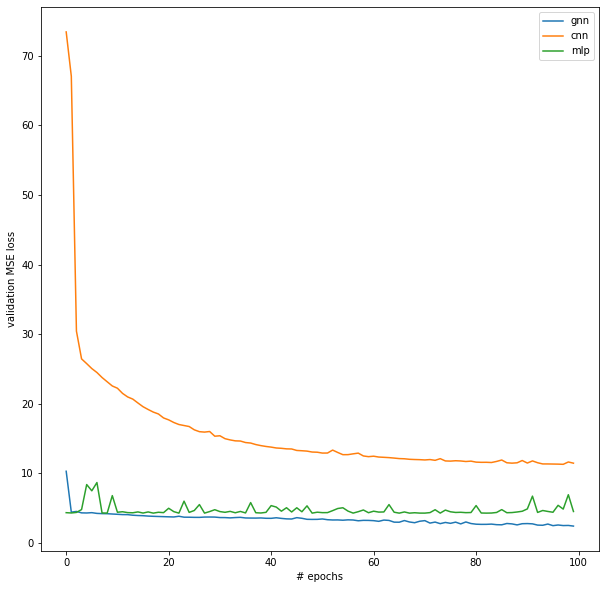

In [ ]:

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(gnn_molecule_results.val_accs,label = 'gnn')
plt.plot(cnn_molecule_results.val_accs,label = 'cnn')
plt.plot(mlp_molecule_results.val_accs,label = 'mlp')

plt.legend()
plt.xlabel('# epochs')
plt.ylabel('validation MSE loss')
plt.show()


##  Out of distribution generalization






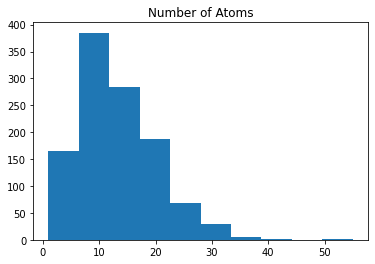

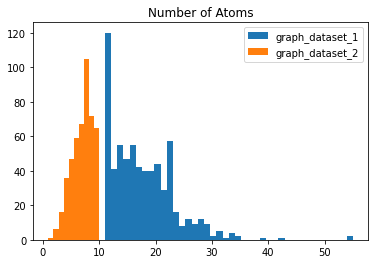

In [ ]:
num_atoms = [g.x.shape[0] for g in graph_dataset]
plt.hist(num_atoms)
plt.title("Number of Atoms")
plt.show() 


# FIXME
graph_dataset_1 = [g for g in graph_dataset if g.x.shape[0] > 10]
graph_dataset_2 = [g for g in graph_dataset if g.x.shape[0] <= 10]



num_atoms_1 = [g.x.shape[0] for g in graph_dataset_1]
num_atoms_2 = [g.x.shape[0] for g in graph_dataset_2]
plt.hist(num_atoms_1,label = 'graph_dataset_1',
         bins = 40)
plt.hist(num_atoms_2,label = 'graph_dataset_2')
plt.title("Number of Atoms")
plt.legend()
plt.show() 

100%|██████████| 21/21 [00:00<00:00, 86.13it/s]


Epoch 0: Train Loss=18.79911186581566 Validation Loss=4.91267499923706


100%|██████████| 21/21 [00:00<00:00, 121.71it/s]


Epoch 1: Train Loss=19.00464432688257 Validation Loss=4.2653198877970375


100%|██████████| 21/21 [00:00<00:00, 132.84it/s]


Epoch 2: Train Loss=15.105444587058349 Validation Loss=2.2579750219980874


100%|██████████| 21/21 [00:00<00:00, 132.19it/s]


Epoch 3: Train Loss=6.52096483427317 Validation Loss=10.130080127716065


100%|██████████| 21/21 [00:00<00:00, 127.53it/s]


Epoch 4: Train Loss=4.455580925808081 Validation Loss=5.999588298797607


100%|██████████| 21/21 [00:00<00:00, 124.54it/s]


Epoch 5: Train Loss=4.192781390456251 Validation Loss=7.1320747375488285


100%|██████████| 21/21 [00:00<00:00, 128.67it/s]


Epoch 6: Train Loss=4.156794908581645 Validation Loss=6.720771185557047


100%|██████████| 21/21 [00:00<00:00, 132.06it/s]


Epoch 7: Train Loss=4.12749063982559 Validation Loss=7.051335239410401


100%|██████████| 21/21 [00:00<00:00, 129.89it/s]


Epoch 8: Train Loss=4.126781435246502 Validation Loss=6.120212237040202


100%|██████████| 21/21 [00:00<00:00, 124.74it/s]


Epoch 9: Train Loss=4.094015483413198 Validation Loss=8.144227218627929


100%|██████████| 21/21 [00:00<00:00, 128.04it/s]


Epoch 10: Train Loss=4.128123306298732 Validation Loss=6.02741486231486


100%|██████████| 21/21 [00:00<00:00, 134.82it/s]


Epoch 11: Train Loss=3.99906365185808 Validation Loss=6.534641297658284


100%|██████████| 21/21 [00:00<00:00, 131.70it/s]


Epoch 12: Train Loss=3.9709013492861582 Validation Loss=6.685150305430095


100%|██████████| 21/21 [00:00<00:00, 120.37it/s]


Epoch 13: Train Loss=3.9527898222255287 Validation Loss=6.0267315864562985


100%|██████████| 21/21 [00:00<00:00, 127.49it/s]


Epoch 14: Train Loss=3.949745111948193 Validation Loss=6.302828852335612


100%|██████████| 21/21 [00:00<00:00, 124.92it/s]


Epoch 15: Train Loss=3.964579329286584 Validation Loss=6.657749970753987


100%|██████████| 21/21 [00:00<00:00, 134.29it/s]


Epoch 16: Train Loss=4.006131023896808 Validation Loss=5.5422563552856445


100%|██████████| 21/21 [00:00<00:00, 125.64it/s]


Epoch 17: Train Loss=3.906476053488306 Validation Loss=6.846028614044189


100%|██████████| 21/21 [00:00<00:00, 128.22it/s]


Epoch 18: Train Loss=3.9214553167371546 Validation Loss=5.145592514673869


100%|██████████| 21/21 [00:00<00:00, 130.87it/s]


Epoch 19: Train Loss=3.9161831392652866 Validation Loss=6.938000837961833


100%|██████████| 21/21 [00:00<00:00, 119.62it/s]


Epoch 20: Train Loss=3.9065097241827753 Validation Loss=7.156663544972738


100%|██████████| 21/21 [00:00<00:00, 67.95it/s]


Epoch 21: Train Loss=3.87243034001962 Validation Loss=6.37657060623169


100%|██████████| 21/21 [00:00<00:00, 49.17it/s]


Epoch 22: Train Loss=3.8316429917570027 Validation Loss=6.048519452412923


100%|██████████| 21/21 [00:00<00:00, 46.37it/s]


Epoch 23: Train Loss=3.7875148798953737 Validation Loss=5.799024550120036


100%|██████████| 21/21 [00:00<00:00, 58.46it/s]


Epoch 24: Train Loss=3.8731981551170884 Validation Loss=6.276327355702718


100%|██████████| 21/21 [00:00<00:00, 52.57it/s]


Epoch 25: Train Loss=3.7787464518183773 Validation Loss=5.956039460500081


100%|██████████| 21/21 [00:00<00:00, 64.66it/s]


Epoch 26: Train Loss=3.8402733616357487 Validation Loss=6.3538435935974125


100%|██████████| 21/21 [00:00<00:00, 59.88it/s]


Epoch 27: Train Loss=3.7492851691223583 Validation Loss=6.2469280878702795


100%|██████████| 21/21 [00:00<00:00, 73.81it/s]


Epoch 28: Train Loss=3.7244930299349126 Validation Loss=5.565841738382975


100%|██████████| 21/21 [00:00<00:00, 126.44it/s]


Epoch 29: Train Loss=3.735124690344539 Validation Loss=6.031206035614014


100%|██████████| 21/21 [00:00<00:00, 136.48it/s]


Epoch 30: Train Loss=3.832741254048244 Validation Loss=6.511324373881022


100%|██████████| 21/21 [00:00<00:00, 133.00it/s]


Epoch 31: Train Loss=3.8537056329456916 Validation Loss=6.2832212766011555


100%|██████████| 21/21 [00:00<00:00, 122.47it/s]


Epoch 32: Train Loss=3.7531753716138048 Validation Loss=6.083431657155355


100%|██████████| 21/21 [00:00<00:00, 131.33it/s]


Epoch 33: Train Loss=3.7401952683796345 Validation Loss=5.412482293446859


100%|██████████| 21/21 [00:00<00:00, 131.82it/s]


Epoch 34: Train Loss=3.7250462824383894 Validation Loss=6.101803334554036


100%|██████████| 21/21 [00:00<00:00, 132.96it/s]


Epoch 35: Train Loss=3.706103875780293 Validation Loss=6.066950194040934


100%|██████████| 21/21 [00:00<00:00, 124.47it/s]


Epoch 36: Train Loss=3.748938246120734 Validation Loss=5.634534581502279


100%|██████████| 21/21 [00:00<00:00, 128.28it/s]


Epoch 37: Train Loss=3.6852010736176757 Validation Loss=6.438426208496094


100%|██████████| 21/21 [00:00<00:00, 130.04it/s]


Epoch 38: Train Loss=3.6493354252846912 Validation Loss=5.215072949727376


100%|██████████| 21/21 [00:00<00:00, 129.90it/s]


Epoch 39: Train Loss=3.7902856800852875 Validation Loss=6.740809408823649


100%|██████████| 21/21 [00:00<00:00, 124.46it/s]


Epoch 40: Train Loss=3.716349254212203 Validation Loss=4.7021110852559405


100%|██████████| 21/21 [00:00<00:00, 130.84it/s]


Epoch 41: Train Loss=3.688012129265232 Validation Loss=6.202936999003092


100%|██████████| 21/21 [00:00<00:00, 129.58it/s]


Epoch 42: Train Loss=3.715992802958553 Validation Loss=5.827359294891357


100%|██████████| 21/21 [00:00<00:00, 132.88it/s]


Epoch 43: Train Loss=3.7851995113624874 Validation Loss=6.891488043467204


100%|██████████| 21/21 [00:00<00:00, 122.10it/s]


Epoch 44: Train Loss=3.663065586218445 Validation Loss=5.580972258249918


100%|██████████| 21/21 [00:00<00:00, 129.49it/s]


Epoch 45: Train Loss=3.710523499086225 Validation Loss=5.710822423299153


100%|██████████| 21/21 [00:00<00:00, 131.51it/s]


Epoch 46: Train Loss=3.7239272203253715 Validation Loss=5.415865564346314


100%|██████████| 21/21 [00:00<00:00, 129.66it/s]


Epoch 47: Train Loss=3.611419880230309 Validation Loss=5.808490180969239


100%|██████████| 21/21 [00:00<00:00, 122.16it/s]


Epoch 48: Train Loss=3.7588207591071523 Validation Loss=5.696382697423299


100%|██████████| 21/21 [00:00<00:00, 123.29it/s]


Epoch 49: Train Loss=3.6159207417307146 Validation Loss=5.883920574188233


100%|██████████| 21/21 [00:00<00:00, 126.38it/s]


Epoch 50: Train Loss=3.6998353382601525 Validation Loss=6.324707063039144


100%|██████████| 21/21 [00:00<00:00, 126.61it/s]


Epoch 51: Train Loss=3.628202042790889 Validation Loss=5.531658124923706


100%|██████████| 21/21 [00:00<00:00, 127.07it/s]


Epoch 52: Train Loss=3.745315833782991 Validation Loss=5.434398682912191


100%|██████████| 21/21 [00:00<00:00, 130.99it/s]


Epoch 53: Train Loss=3.689189816462419 Validation Loss=5.81858213742574


100%|██████████| 21/21 [00:00<00:00, 129.75it/s]


Epoch 54: Train Loss=3.687667535645026 Validation Loss=6.832732518513997


100%|██████████| 21/21 [00:00<00:00, 132.07it/s]


Epoch 55: Train Loss=3.7146542151249715 Validation Loss=6.762545871734619


100%|██████████| 21/21 [00:00<00:00, 127.64it/s]


Epoch 56: Train Loss=3.6547489170019456 Validation Loss=5.826127401987711


100%|██████████| 21/21 [00:00<00:00, 129.53it/s]


Epoch 57: Train Loss=3.6518407662888586 Validation Loss=5.957049703598022


100%|██████████| 21/21 [00:00<00:00, 127.31it/s]


Epoch 58: Train Loss=3.5531782120001703 Validation Loss=5.5776699384053545


100%|██████████| 21/21 [00:00<00:00, 128.67it/s]


Epoch 59: Train Loss=3.709556711143598 Validation Loss=7.139976119995117


100%|██████████| 21/21 [00:00<00:00, 127.81it/s]


Epoch 60: Train Loss=3.60783959061505 Validation Loss=5.188851404190063


100%|██████████| 21/21 [00:00<00:00, 134.12it/s]


Epoch 61: Train Loss=3.611766622478338 Validation Loss=5.164153639475504


100%|██████████| 21/21 [00:00<00:00, 130.47it/s]


Epoch 62: Train Loss=3.5166029327452457 Validation Loss=5.396593618392944


100%|██████████| 21/21 [00:00<00:00, 130.90it/s]


Epoch 63: Train Loss=3.532585243352539 Validation Loss=5.4841209888458256


100%|██████████| 21/21 [00:00<00:00, 129.65it/s]


Epoch 64: Train Loss=3.61968280493117 Validation Loss=6.739327144622803


100%|██████████| 21/21 [00:00<00:00, 121.59it/s]


Epoch 65: Train Loss=3.518234673766341 Validation Loss=6.270172850290934


100%|██████████| 21/21 [00:00<00:00, 123.39it/s]


Epoch 66: Train Loss=3.546653063695963 Validation Loss=5.843107048670451


100%|██████████| 21/21 [00:00<00:00, 128.03it/s]


Epoch 67: Train Loss=3.464242732316792 Validation Loss=5.751029189427694


100%|██████████| 21/21 [00:00<00:00, 127.70it/s]


Epoch 68: Train Loss=3.538272927478691 Validation Loss=6.837735303243002


100%|██████████| 21/21 [00:00<00:00, 127.66it/s]


Epoch 69: Train Loss=3.591552981794625 Validation Loss=5.871437279383342


100%|██████████| 21/21 [00:00<00:00, 122.15it/s]


Epoch 70: Train Loss=3.489809820058835 Validation Loss=5.155632909138998


100%|██████████| 21/21 [00:00<00:00, 128.88it/s]


Epoch 71: Train Loss=3.5094885518154877 Validation Loss=6.383187993367513


100%|██████████| 21/21 [00:00<00:00, 124.32it/s]


Epoch 72: Train Loss=3.4523447453502687 Validation Loss=5.858340326944987


100%|██████████| 21/21 [00:00<00:00, 125.18it/s]


Epoch 73: Train Loss=3.437282464331691 Validation Loss=6.436144669850667


100%|██████████| 21/21 [00:00<00:00, 125.51it/s]


Epoch 74: Train Loss=3.4198829116057925 Validation Loss=6.991797924041748


100%|██████████| 21/21 [00:00<00:00, 127.12it/s]


Epoch 75: Train Loss=3.411142219539822 Validation Loss=5.49818058013916


100%|██████████| 21/21 [00:00<00:00, 129.21it/s]


Epoch 76: Train Loss=3.446476669038872 Validation Loss=6.0508045355478925


100%|██████████| 21/21 [00:00<00:00, 124.32it/s]


Epoch 77: Train Loss=3.352278117666431 Validation Loss=6.58777592976888


100%|██████████| 21/21 [00:00<00:00, 126.09it/s]


Epoch 78: Train Loss=3.4613520136111213 Validation Loss=6.144395256042481


100%|██████████| 21/21 [00:00<00:00, 125.05it/s]


Epoch 79: Train Loss=3.289438578016385 Validation Loss=6.440004634857178


100%|██████████| 21/21 [00:00<00:00, 125.84it/s]


Epoch 80: Train Loss=3.321978153336939 Validation Loss=6.026993592580159


100%|██████████| 21/21 [00:00<00:00, 125.73it/s]


Epoch 81: Train Loss=3.2840162147391836 Validation Loss=5.871902783711751


100%|██████████| 21/21 [00:00<00:00, 127.36it/s]


Epoch 82: Train Loss=3.3309362995686462 Validation Loss=6.431494585673014


100%|██████████| 21/21 [00:00<00:00, 127.94it/s]


Epoch 83: Train Loss=3.3110076353098776 Validation Loss=6.392161019643148


100%|██████████| 21/21 [00:00<00:00, 130.28it/s]


Epoch 84: Train Loss=3.2640409988313714 Validation Loss=6.0081343173980715


100%|██████████| 21/21 [00:00<00:00, 125.64it/s]


Epoch 85: Train Loss=3.3066396454125635 Validation Loss=6.7251407941182455


100%|██████████| 21/21 [00:00<00:00, 129.97it/s]


Epoch 86: Train Loss=3.3193284090509017 Validation Loss=6.667767461140951


100%|██████████| 21/21 [00:00<00:00, 130.25it/s]


Epoch 87: Train Loss=3.18879500370248 Validation Loss=5.828965044021606


100%|██████████| 21/21 [00:00<00:00, 129.85it/s]


Epoch 88: Train Loss=3.219825127456408 Validation Loss=6.422857570648193


100%|██████████| 21/21 [00:00<00:00, 126.58it/s]


Epoch 89: Train Loss=3.204093665297723 Validation Loss=5.374993864695231


100%|██████████| 21/21 [00:00<00:00, 128.44it/s]


Epoch 90: Train Loss=3.214602213549987 Validation Loss=5.351762342453003


100%|██████████| 21/21 [00:00<00:00, 131.12it/s]


Epoch 91: Train Loss=3.2438882694096973 Validation Loss=6.562632465362549


100%|██████████| 21/21 [00:00<00:00, 125.27it/s]


Epoch 92: Train Loss=3.197416584195843 Validation Loss=5.871376864115397


100%|██████████| 21/21 [00:00<00:00, 131.20it/s]


Epoch 93: Train Loss=3.111590302203485 Validation Loss=7.26986083984375


100%|██████████| 21/21 [00:00<00:00, 128.81it/s]


Epoch 94: Train Loss=3.130202930892005 Validation Loss=6.249890899658203


100%|██████████| 21/21 [00:00<00:00, 126.85it/s]


Epoch 95: Train Loss=3.19483295138509 Validation Loss=6.685941441853841


100%|██████████| 21/21 [00:00<00:00, 131.46it/s]


Epoch 96: Train Loss=3.1469605721442613 Validation Loss=6.346383825937907


100%|██████████| 21/21 [00:00<00:00, 129.40it/s]


Epoch 97: Train Loss=3.1131860223904897 Validation Loss=7.492974472045899


100%|██████████| 21/21 [00:00<00:00, 129.18it/s]


Epoch 98: Train Loss=3.0516160140316435 Validation Loss=7.343250211079916


100%|██████████| 21/21 [00:00<00:00, 126.93it/s]


Epoch 99: Train Loss=3.0689069458883944 Validation Loss=6.600746440887451


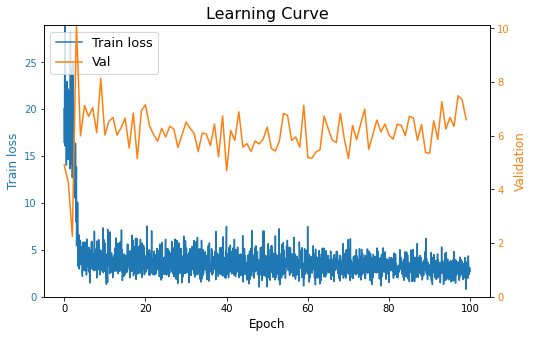

In [ ]:
model = GNN(in_channels=9, out_channels=1).to(device)
gnn_molecule_results_12 = train_nn(model, graph_dataset_1, graph_dataset_2, graph=True, regression=True, lr=5e-4, criterion=nn.MSELoss(), num_epochs=100)
learning_curve(gnn_molecule_results_12)

100%|██████████| 15/15 [00:00<00:00, 131.45it/s]


Epoch 0: Train Loss=5.368403879801432 Validation Loss=19.016778628031414


100%|██████████| 15/15 [00:00<00:00, 128.02it/s]


Epoch 1: Train Loss=5.2159304756588405 Validation Loss=17.29247824350993


100%|██████████| 15/15 [00:00<00:00, 122.40it/s]


Epoch 2: Train Loss=4.115152216875995 Validation Loss=12.92746316818964


100%|██████████| 15/15 [00:00<00:00, 115.77it/s]


Epoch 3: Train Loss=2.673947444023321 Validation Loss=7.895007088070824


100%|██████████| 15/15 [00:00<00:00, 130.80it/s]


Epoch 4: Train Loss=2.5409132315358605 Validation Loss=9.344226700919014


100%|██████████| 15/15 [00:00<00:00, 127.83it/s]


Epoch 5: Train Loss=2.4833207850564922 Validation Loss=9.044506322769891


100%|██████████| 15/15 [00:00<00:00, 120.77it/s]


Epoch 6: Train Loss=2.480570646954307 Validation Loss=9.13529600415911


100%|██████████| 15/15 [00:00<00:00, 123.23it/s]


Epoch 7: Train Loss=2.4593936425336684 Validation Loss=8.984535762241908


100%|██████████| 15/15 [00:00<00:00, 126.09it/s]


Epoch 8: Train Loss=2.416856719532864 Validation Loss=8.995751744224911


100%|██████████| 15/15 [00:00<00:00, 125.17it/s]


Epoch 9: Train Loss=2.4140803783124856 Validation Loss=8.674777144477481


100%|██████████| 15/15 [00:00<00:00, 128.26it/s]


Epoch 10: Train Loss=2.3837882198822906 Validation Loss=8.712592283884684


100%|██████████| 15/15 [00:00<00:00, 123.01it/s]


Epoch 11: Train Loss=2.3803770695655375 Validation Loss=8.61551741191319


100%|██████████| 15/15 [00:00<00:00, 119.14it/s]


Epoch 12: Train Loss=2.3730990579030835 Validation Loss=8.723857652573358


100%|██████████| 15/15 [00:00<00:00, 126.08it/s]


Epoch 13: Train Loss=2.3636281072451135 Validation Loss=8.472788106827508


100%|██████████| 15/15 [00:00<00:00, 126.52it/s]


Epoch 14: Train Loss=2.3618491065459346 Validation Loss=8.617558388482957


100%|██████████| 15/15 [00:00<00:00, 127.62it/s]


Epoch 15: Train Loss=2.3631394728816675 Validation Loss=8.549231756301154


100%|██████████| 15/15 [00:00<00:00, 123.26it/s]


Epoch 16: Train Loss=2.372724109390028 Validation Loss=8.873417808896018


100%|██████████| 15/15 [00:00<00:00, 126.55it/s]


Epoch 17: Train Loss=2.342894748416122 Validation Loss=8.430729866027832


100%|██████████| 15/15 [00:00<00:00, 129.25it/s]


Epoch 18: Train Loss=2.335998945472411 Validation Loss=8.615760280972435


100%|██████████| 15/15 [00:00<00:00, 121.77it/s]


Epoch 19: Train Loss=2.3212878341832277 Validation Loss=8.53929158619472


100%|██████████| 15/15 [00:00<00:00, 124.35it/s]


Epoch 20: Train Loss=2.319829485385673 Validation Loss=8.800743125733876


100%|██████████| 15/15 [00:00<00:00, 128.11it/s]


Epoch 21: Train Loss=2.308586678343949 Validation Loss=8.147519157046364


100%|██████████| 15/15 [00:00<00:00, 127.17it/s]


Epoch 22: Train Loss=2.297362102497812 Validation Loss=8.296989486331032


100%|██████████| 15/15 [00:00<00:00, 131.47it/s]


Epoch 23: Train Loss=2.2962233631762663 Validation Loss=8.146944477444602


100%|██████████| 15/15 [00:00<00:00, 132.35it/s]


Epoch 24: Train Loss=2.281217830770233 Validation Loss=8.996059644789923


100%|██████████| 15/15 [00:00<00:00, 116.96it/s]


Epoch 25: Train Loss=2.3031240792667216 Validation Loss=7.8140304656255815


100%|██████████| 15/15 [00:00<00:00, 126.78it/s]


Epoch 26: Train Loss=2.267969521493351 Validation Loss=8.659914266495477


100%|██████████| 15/15 [00:00<00:00, 125.68it/s]


Epoch 27: Train Loss=2.225564934982898 Validation Loss=7.979372864677792


100%|██████████| 15/15 [00:00<00:00, 123.07it/s]


Epoch 28: Train Loss=2.2069152022847893 Validation Loss=8.22756830851237


100%|██████████| 15/15 [00:00<00:00, 126.80it/s]


Epoch 29: Train Loss=2.1966605466302855 Validation Loss=8.927743752797445


100%|██████████| 15/15 [00:00<00:00, 131.40it/s]


Epoch 30: Train Loss=2.1739508011718365 Validation Loss=7.2795944440932505


100%|██████████| 15/15 [00:00<00:00, 130.58it/s]


Epoch 31: Train Loss=2.1864593194509863 Validation Loss=9.79879279363723


100%|██████████| 15/15 [00:00<00:00, 131.62it/s]


Epoch 32: Train Loss=2.2418581496780803 Validation Loss=8.174448353903633


100%|██████████| 15/15 [00:00<00:00, 128.37it/s]


Epoch 33: Train Loss=2.157476641410627 Validation Loss=7.649904182979038


100%|██████████| 15/15 [00:00<00:00, 112.23it/s]


Epoch 34: Train Loss=2.1132367993509793 Validation Loss=7.974241915203276


100%|██████████| 15/15 [00:00<00:00, 126.65it/s]


Epoch 35: Train Loss=2.0617126633400122 Validation Loss=8.034451598212833


100%|██████████| 15/15 [00:00<00:00, 126.30it/s]


Epoch 36: Train Loss=2.058958469560904 Validation Loss=8.190541199275426


100%|██████████| 15/15 [00:00<00:00, 128.86it/s]


Epoch 37: Train Loss=2.018472516452681 Validation Loss=7.690247830890474


100%|██████████| 15/15 [00:00<00:00, 130.06it/s]


Epoch 38: Train Loss=1.9679855720146109 Validation Loss=8.069835912613641


100%|██████████| 15/15 [00:00<00:00, 125.35it/s]


Epoch 39: Train Loss=1.9313213627599586 Validation Loss=8.954712708791098


100%|██████████| 15/15 [00:00<00:00, 127.76it/s]


Epoch 40: Train Loss=1.8959778454639045 Validation Loss=7.248579206920805


100%|██████████| 15/15 [00:00<00:00, 130.20it/s]


Epoch 41: Train Loss=1.8233797544024886 Validation Loss=7.2097797847929455


100%|██████████| 15/15 [00:00<00:00, 129.28it/s]


Epoch 42: Train Loss=1.7433366854573786 Validation Loss=8.690404937380837


100%|██████████| 15/15 [00:00<00:00, 124.94it/s]


Epoch 43: Train Loss=1.6740729496186675 Validation Loss=9.360279469262986


100%|██████████| 15/15 [00:00<00:00, 131.55it/s]


Epoch 44: Train Loss=1.5938120264828584 Validation Loss=10.898498625982375


100%|██████████| 15/15 [00:00<00:00, 124.78it/s]


Epoch 45: Train Loss=1.7031106894481207 Validation Loss=7.950687521979923


100%|██████████| 15/15 [00:00<00:00, 129.07it/s]


Epoch 46: Train Loss=1.5474728660137655 Validation Loss=8.167216278257824


100%|██████████| 15/15 [00:00<00:00, 120.20it/s]


Epoch 47: Train Loss=1.4667010765363853 Validation Loss=7.353906290871756


100%|██████████| 15/15 [00:00<00:00, 130.70it/s]


Epoch 48: Train Loss=1.4538613787034491 Validation Loss=6.209736528850737


100%|██████████| 15/15 [00:00<00:00, 126.90it/s]


Epoch 49: Train Loss=1.4692109639826043 Validation Loss=8.947646481650215


100%|██████████| 15/15 [00:00<00:00, 127.29it/s]


Epoch 50: Train Loss=1.3634181010417317 Validation Loss=8.78633687609718


100%|██████████| 15/15 [00:00<00:00, 124.19it/s]


Epoch 51: Train Loss=1.3365473428546863 Validation Loss=9.06981543132237


100%|██████████| 15/15 [00:00<00:00, 127.53it/s]


Epoch 52: Train Loss=1.3208102880529529 Validation Loss=10.080295244852701


100%|██████████| 15/15 [00:00<00:00, 126.57it/s]


Epoch 53: Train Loss=1.2808264712400699 Validation Loss=10.031716233208066


100%|██████████| 15/15 [00:00<00:00, 125.20it/s]


Epoch 54: Train Loss=1.2032736117303864 Validation Loss=8.780471461159843


100%|██████████| 15/15 [00:00<00:00, 128.53it/s]


Epoch 55: Train Loss=1.2412484776620105 Validation Loss=10.62118825458345


100%|██████████| 15/15 [00:00<00:00, 130.23it/s]


Epoch 56: Train Loss=1.295960207062589 Validation Loss=8.933577605656215


100%|██████████| 15/15 [00:00<00:00, 130.92it/s]


Epoch 57: Train Loss=1.1772052698186786 Validation Loss=8.405110404604958


100%|██████████| 15/15 [00:00<00:00, 122.32it/s]


Epoch 58: Train Loss=1.1374099297844817 Validation Loss=8.813675176529657


100%|██████████| 15/15 [00:00<00:00, 123.44it/s]


Epoch 59: Train Loss=1.1440740588209592 Validation Loss=9.460840702056885


100%|██████████| 15/15 [00:00<00:00, 129.01it/s]


Epoch 60: Train Loss=1.184147598762655 Validation Loss=8.019020012446813


100%|██████████| 15/15 [00:00<00:00, 121.01it/s]


Epoch 61: Train Loss=1.179995338282277 Validation Loss=7.2096992674328035


100%|██████████| 15/15 [00:00<00:00, 122.30it/s]


Epoch 62: Train Loss=1.1102966096772942 Validation Loss=7.363989216940744


100%|██████████| 15/15 [00:00<00:00, 123.22it/s]


Epoch 63: Train Loss=1.0956081392154045 Validation Loss=8.93433173497518


100%|██████████| 15/15 [00:00<00:00, 124.09it/s]


Epoch 64: Train Loss=1.0625951624034837 Validation Loss=10.10987377166748


100%|██████████| 15/15 [00:00<00:00, 120.66it/s]


Epoch 65: Train Loss=1.1453317187635037 Validation Loss=7.520333539871943


100%|██████████| 15/15 [00:00<00:00, 129.62it/s]


Epoch 66: Train Loss=1.0818533088260753 Validation Loss=8.392235551561628


100%|██████████| 15/15 [00:00<00:00, 128.59it/s]


Epoch 67: Train Loss=1.0170068527956397 Validation Loss=8.323962643032981


100%|██████████| 15/15 [00:00<00:00, 127.87it/s]


Epoch 68: Train Loss=1.0187523390564626 Validation Loss=7.982023806799026


100%|██████████| 15/15 [00:00<00:00, 120.66it/s]


Epoch 69: Train Loss=1.0080459278538048 Validation Loss=9.29509010769072


100%|██████████| 15/15 [00:00<00:00, 119.40it/s]


Epoch 70: Train Loss=1.0083750695765958 Validation Loss=9.149023396628243


100%|██████████| 15/15 [00:00<00:00, 123.24it/s]


Epoch 71: Train Loss=0.9725419257136249 Validation Loss=7.781386874970936


100%|██████████| 15/15 [00:00<00:00, 128.46it/s]


Epoch 72: Train Loss=0.9969370721052226 Validation Loss=10.167065347943987


100%|██████████| 15/15 [00:00<00:00, 120.36it/s]


Epoch 73: Train Loss=0.9809749388580199 Validation Loss=9.704817771911621


100%|██████████| 15/15 [00:00<00:00, 129.21it/s]


Epoch 74: Train Loss=0.9664806979489636 Validation Loss=8.176347482772101


100%|██████████| 15/15 [00:00<00:00, 119.22it/s]


Epoch 75: Train Loss=0.9651649094793022 Validation Loss=8.172604583558583


100%|██████████| 15/15 [00:00<00:00, 131.58it/s]


Epoch 76: Train Loss=0.98328568602385 Validation Loss=9.89917771021525


100%|██████████| 15/15 [00:00<00:00, 121.19it/s]


Epoch 77: Train Loss=0.9502436333661489 Validation Loss=9.470999763125466


100%|██████████| 15/15 [00:00<00:00, 122.35it/s]


Epoch 78: Train Loss=0.9362293270810791 Validation Loss=9.311963490077428


100%|██████████| 15/15 [00:00<00:00, 125.14it/s]


Epoch 79: Train Loss=0.9507180597224789 Validation Loss=8.745360419863747


100%|██████████| 15/15 [00:00<00:00, 126.46it/s]


Epoch 80: Train Loss=0.9056489238860803 Validation Loss=9.034390449523926


100%|██████████| 15/15 [00:00<00:00, 126.85it/s]


Epoch 81: Train Loss=0.9160402699955477 Validation Loss=11.257166680835542


100%|██████████| 15/15 [00:00<00:00, 127.62it/s]


Epoch 82: Train Loss=0.9140092312272932 Validation Loss=10.841414519718715


100%|██████████| 15/15 [00:00<00:00, 130.10it/s]


Epoch 83: Train Loss=0.9415547462236653 Validation Loss=9.319175697508312


100%|██████████| 15/15 [00:00<00:00, 129.96it/s]


Epoch 84: Train Loss=0.9103374932337587 Validation Loss=8.165407044546944


100%|██████████| 15/15 [00:00<00:00, 126.57it/s]


Epoch 85: Train Loss=0.8921657334044826 Validation Loss=9.331960995992025


100%|██████████| 15/15 [00:00<00:00, 122.11it/s]


Epoch 86: Train Loss=0.8897511292184409 Validation Loss=9.724327246348063


100%|██████████| 15/15 [00:00<00:00, 120.75it/s]


Epoch 87: Train Loss=0.8988165413583982 Validation Loss=8.191203798566546


100%|██████████| 15/15 [00:00<00:00, 121.85it/s]


Epoch 88: Train Loss=0.8918188502738587 Validation Loss=8.094785485948835


100%|██████████| 15/15 [00:00<00:00, 128.90it/s]


Epoch 89: Train Loss=0.9488930562492855 Validation Loss=8.857087748391288


100%|██████████| 15/15 [00:00<00:00, 118.50it/s]


Epoch 90: Train Loss=0.8951433450603263 Validation Loss=10.39684940519787


100%|██████████| 15/15 [00:00<00:00, 126.59it/s]


Epoch 91: Train Loss=0.9503693153502132 Validation Loss=8.590386163620721


100%|██████████| 15/15 [00:00<00:00, 133.45it/s]


Epoch 92: Train Loss=0.8704793822105831 Validation Loss=8.198767911820184


100%|██████████| 15/15 [00:00<00:00, 129.26it/s]


Epoch 93: Train Loss=0.8932002946491778 Validation Loss=9.132817200251989


100%|██████████| 15/15 [00:00<00:00, 130.84it/s]


Epoch 94: Train Loss=0.8612728884799993 Validation Loss=8.173356215159098


100%|██████████| 15/15 [00:00<00:00, 128.81it/s]


Epoch 95: Train Loss=0.8607455086110943 Validation Loss=8.570729846046085


100%|██████████| 15/15 [00:00<00:00, 123.49it/s]


Epoch 96: Train Loss=0.8725757611552802 Validation Loss=9.548075653257824


100%|██████████| 15/15 [00:00<00:00, 132.27it/s]


Epoch 97: Train Loss=0.8553560416748784 Validation Loss=10.093952178955078


100%|██████████| 15/15 [00:00<00:00, 131.43it/s]


Epoch 98: Train Loss=0.8984536571029202 Validation Loss=9.102934973580497


100%|██████████| 15/15 [00:00<00:00, 126.11it/s]


Epoch 99: Train Loss=0.8501158955542469 Validation Loss=10.244148935590472


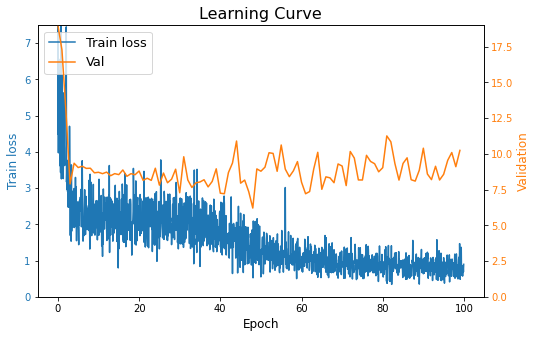

In [ ]:
model = GNN(in_channels=9, out_channels=1).to(device)
gnn_molecule_results_21 = train_nn(model, graph_dataset_2, graph_dataset_1, graph=True, regression=True, lr=5e-4, criterion=nn.MSELoss(), num_epochs=100)
learning_curve(gnn_molecule_results_21)

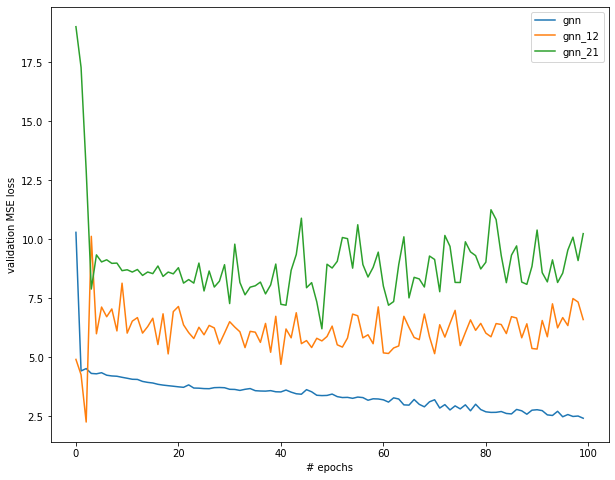

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(gnn_molecule_results.val_accs,label = 'gnn')
plt.plot(gnn_molecule_results_12.val_accs,label = 'gnn_12')
plt.plot(gnn_molecule_results_21.val_accs,label = 'gnn_21')

plt.legend()
plt.xlabel('# epochs')
plt.ylabel('validation MSE loss')
plt.show()